# Registers in ViTs

This notebook contains code to replicate and extend the works of Darcet et al. 2024 in [Vision Transformers Need Registers](https://arxiv.org/abs/2309.16588)

## Setup

In [39]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import datasets

import timm
from timm.models._features import feature_take_indices

import numpy as np

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from tqdm.notebook import tqdm

import os
from typing import Sequence, List, Tuple, Union, Optional, Any
from functools import partial
from collections import defaultdict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from google.colab import drive

import drive.MyDrive.checkpoints.deit_reg as lib_deit_reg;
import drive.MyDrive.checkpoints.deit_source as lib_deit_source;

import drive.MyDrive.checkpoints.deit_reg.models_v2 as models_reg;
import drive.MyDrive.checkpoints.deit_source.models_v2 as models_source;

from drive.MyDrive.checkpoints.deit_reg.models_v2 import deit_small_patch16_LS as deit_reg_small;
from drive.MyDrive.checkpoints.deit_source.models_v2 import deit_small_patch16_LS as deit_source_small;

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/content/drive/MyDrive/checkpoints/deit_source/models_v2.py:271: UserWarning: Overwriting deit_tiny_patch16_LS in registry with drive.MyDrive.checkpoints.deit_source.models_v2.deit_tiny_patch16_LS. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/content/drive/MyDrive/checkpoints/deit_source/models_v2.py:280: UserWarning: Overwriting deit_small_patch16_LS in registry wit

In [3]:
import matplotlib as mpl
import matplotlib.font_manager as fm
print(mpl.__version__)

!wget -O TimesNewRoman.ttf https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf
font_dirs = ["/content/"]
font_files = fm.findSystemFonts(fontpaths=font_dirs, fontext='ttf')
for font_file in font_files:
    print(font_file) if 'TimesNewRoman' in font_file else None
    fm.fontManager.addfont(font_file)

plt.rcParams["font.family"] = "Times New Roman"


In [4]:
VALID_MAPS = ["spatial_embs",
                "spatial_atts",
                "spatial_mlps",
                "prefix_embs",
                "prefix_atts",
                "prefix_mlps"
  ]

MODELS_PATH = {"registers": "/content/drive/MyDrive/checkpoints/reg_checkpoints",
               "source": "/content/drive/MyDrive/checkpoints/source_checkpoints"}

DATA_SOURCE = 'drive/MyDrive/'
DATA_PATH = "data/"

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)

preprocess = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
      transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN,
                            std=IMAGENET_DEFAULT_STD)
  ])


In [6]:
download = True
if os.path.exists(DATA_SOURCE + "imagenette2.tgz"):
  !mkdir {DATA_PATH}
  !tar -xzf {DATA_SOURCE + "imagenette2.tgz"} -C {DATA_PATH}
  download = False


dataset = datasets.Imagenette(
  root=DATA_PATH,
  download=download,
  transform=preprocess
)

data_loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [7]:
n_samples = 10
sample_images, sample_labels = next(iter(data_loader))
assert len(sample_images) >= n_samples
sample = sample_images[:n_samples]

## Utilities

In [23]:
# @title generate intermediate maps for embeddings, attention and mlp
def get_all_intermediates(model,
                          input_tensor,
                          layers: int,
                          **kwargs) -> dict:

  # Perform forward pass to get feature normal maps
  with torch.no_grad():
    if "get_intermediate_layers" in dir(model):
      out = model.get_intermediate_layers(input_tensor,
                                            n=layers,
                                            reshape=True,
                                            return_class_token=True,
                                            norm=False)

      outs = {"spatial_embs": [e[0].cpu().numpy().transpose((0,2,3,1))
                              for e in out],
              "prefix_embs": [np.expand_dims(e[1].cpu().numpy(), axis=1)
                              for e in out]}

    elif "forward_intermediates" in dir(model):
      emb, att, mlp, cls = custom_forward(model,
                                     input_tensor,
                                     intermediates_only=True,
                                     return_att_mlp=True,
                                     return_prefix_tokens=True,
                                     )
      outs = dict()
      outs["spatial_embs"] = [e.cpu().numpy() for e in emb]
      outs["spatial_atts"] = [a.cpu().numpy() for a in att]
      outs["spatial_mlps"] = [m.cpu().numpy() for m in mlp]
      outs["prefix_atts"] = [c.cpu().numpy() for c in cls]

    else:
      try:
        outs = reg_forward(model,
                           input_tensor,
                           return_intermed=True,
                           return_att_mlp=True,
                           return_prefix_tokens=True,
                           convert_to_numpy=True,
                           )
      except Exception as e:
        raise ValueError("Model not supported")

  return outs

In [9]:
# @title Visualize normal and attention maps for individual images
def visualize_emb_att_mlp(model,
                          images,
                          layers_to_visualize: int | Sequence ,
                          maps_to_visualize: Sequence[str],
                          output_format="auto",
                          **kwargs):

  if not model:
    return

  if isinstance(layers_to_visualize, int):
    layers_to_visualize = list(range(layers_to_visualize))

  if any([i not in VALID_MAPS for i in maps_to_visualize]):
    raise ValueError(f"maps_to_visualize must be one of {VALID_MAPS}")

  layers_total = max(layers_to_visualize) + 1
  try:
    layers_total = model.n_blocks
  except AttributeError:
    pass

  model.to(device)

  vis_data = []

  # run model on images, extract the intermediate information and process it
  for n_image, input_tensor in enumerate(images):
    if len(input_tensor.shape) == 3:
      input_tensor = input_tensor.unsqueeze(0)
    input_tensor = input_tensor.to(device)

    data = get_all_intermediates(model, input_tensor, layers_total)
    vis_data.append({map: data[map] for map in maps_to_visualize})

  # Visualize spatial tokens
  if any([m.startswith("spatial") for m in maps_to_visualize]):
    spatial_maps = [i for i in maps_to_visualize if i.startswith("spatial")]
    plot_spatial(images, vis_data, layers_to_visualize, spatial_maps, output_format,
                 log_norm=kwargs.get("log_norm", True),
                 norm_along_layers=kwargs.get("norm_along_layers", False))

  # Visualize prefix tokens

  if any([m.startswith("prefix") for m in maps_to_visualize]):
    prefix_maps = [i for i in maps_to_visualize if i.startswith("prefix")]
    plot_prefix(images, vis_data, layers_to_visualize, prefix_maps, output_format)


In [10]:
# @title plot spatial tokens (patches)
def plot_spatial(images,
                 vis_data,
                 layers_to_visualize,
                 maps_to_visualize,
                 output_format="auto",
                 log_norm=True,
                 norm_along_layers=False):

  if any([m.startswith("prefix") for m in maps_to_visualize]):
    raise ValueError("Only supports spatial maps")

  offset = 2 if norm_along_layers else 1

  if output_format == "auto":
    output_format = ((len(layers_to_visualize)+offset)*2,
                     len(images)*2*len(maps_to_visualize))

  # Set up the plot with an extra column for the norms
  fig, ax = plt.subplots(len(images)*len(maps_to_visualize),
                         len(layers_to_visualize) + offset,
                         figsize=output_format,
                         squeeze=False)

  # for each image and each map to visualize
  for n_image, image in enumerate(images):
    n_maps=0
    for map in maps_to_visualize:

      data = vis_data[n_image][map]

      # to visualize how moch each token is attended to,
      # take the mean over all heads and all attending tokens
      if map == "spatial_atts":
        norm_maps = [map.squeeze().mean(axis=(0, 1)) for map in data]

      # for other maps, take the L2 norm over last dimension (embedding)
      else:
        norm_maps = [np.linalg.norm(map.squeeze(), axis=-1) for map in data]

      # for attention per layer heatmap, flatten all norms into 1d list
      emb_list = np.concatenate([d.flatten() for d in norm_maps])
      layer_list = np.repeat(list(range(len(norm_maps))),
                             np.prod(norm_maps[0].shape))

      plot_row_spatial(ax,
                       n_image*len(maps_to_visualize)+n_maps,
                       image,
                       norm_maps,
                       emb_list,
                       layer_list,
                       layers_to_visualize,
                       map if len(maps_to_visualize) > 1 else "",
                       log_norm=log_norm,
                       norm_along_layers=norm_along_layers
                       )
      n_maps+=1

  # Set titles only to first row
  ax[0, 0].set_title('Input Image')
  if norm_along_layers:
    ax[0, 1].set_title('Norm Distribution')
    ax[-1, 1].xaxis.set_visible(True)
    ax[-1, 1].set_xlabel('Layer')

  for i in range(len(layers_to_visualize)):
    ax[0, i+offset].set_title(f'Layer {layers_to_visualize[i]}')

  plt.tight_layout()
  plt.show()

def plot_row_spatial(ax, row, input_tensor, norm_maps, norm_list, layer_list, layers_to_visualize, title, log_norm=True, norm_along_layers=False):
  layers_total = max(layer_list) + 1
  offset = 2 if norm_along_layers else 1
  # Display the original image

  image = input_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
  image = (image - image.min()) / (image.max() - image.min())
  image = Image.fromarray((image * 255).astype(np.uint8))
  ax[row, 0].imshow(image)
  ax[row, 0].xaxis.set_visible(False)
  ax[row, 0].yaxis.set_visible(True)
  ax[row, 0].set_yticks([])
  ax[row, 0].set_ylabel(title)

  if norm_along_layers:
    # display the norm distribution along layers
    heatmap, xedges, yedges = np.histogram2d(layer_list, norm_list,
                                              bins=[layers_total, 50])
    heatmap[heatmap == 0] = heatmap[heatmap > 0].min()/10
    ax[row, 1].imshow(heatmap.T,
                      cmap='viridis',
                      origin='lower',
                      norm=LogNorm(),
                      aspect="auto",
                      extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                      interpolation='none',
                      zorder=0
                      )
    ax[row, 1].xaxis.set_visible(False)
    ax[row, 1].yaxis.set_visible(False)

  # Display the norm maps for each layer
  for n, i_map in enumerate(layers_to_visualize):
    ax[row, n+offset].imshow(norm_maps[i_map],
                        #  norm=LogNorm() if log_norm else None,
                        )
    ax[row, n+offset].axis('off')


In [11]:
# @title plot prefix tokens (CLS + REG)

def plot_prefix(images,
                vis_data,
                layers_to_visualize,
                maps_to_visualize,
                output_format="auto",
                log_norm=True,
                feature_size=(14, 14),
                debug=False
    ):



  if any([m.startswith("spatial") for m in maps_to_visualize]):
    raise ValueError("Only supports prefix maps")

  n_prefix_tokens = 5

  if output_format == "auto":
    output_format = (
      (n_prefix_tokens + 1)*2,
      len(images)*len(maps_to_visualize*len(layers_to_visualize))*2,
    )


  # Set up the plot with an extra column for the norms
  fig, ax = plt.subplots(len(images)*len(maps_to_visualize)*len(layers_to_visualize),
                         n_prefix_tokens + 1,
                         figsize=output_format
                         )


  row=0
  for n_image, input_tensor in enumerate(images):
    for m in maps_to_visualize:
      for n_layer in layers_to_visualize:

        if m != "prefix_atts":
          raise ValueError("Only prefix_atts is implemented")

        # plot attention maps for CLS and REG tokens at each layer

        # take mean over attention heads
        data = vis_data[n_image][m][n_layer]
        att_maps = data.squeeze(0).mean(axis=(0))

        if debug and n_image == 0:
          print(data.shape)
          print(att_maps.shape)

        # split attention to prefix and spatial tokens
        prefix_values = att_maps[:, :n_prefix_tokens]
        att_maps = att_maps[:, n_prefix_tokens:]

        # reshape attention to spatial tokens to 2d map
        att_maps = att_maps.reshape(n_prefix_tokens, *feature_size)

        image = input_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        image = (image - image.min()) / (image.max() - image.min())
        image = Image.fromarray((image * 255).astype(np.uint8))
        ax[row, 0].imshow(image)
        if len(layers_to_visualize) == 1:
          ax[row, 0].set_axis_off()
        else:
          ax[row, 0].xaxis.set_visible(False)
          ax[row, 0].yaxis.set_visible(True)
          ax[row, 0].set_yticks([])
          ax[row, 0].set_ylabel(f'Layer {n_layer}')

        # Display the attention maps for each prefix token
        for n, map in enumerate(att_maps):
          ax[row, n+1].imshow(map, norm=LogNorm() if log_norm else None, )
          ax[row, n+1].axis('off')

        row+=1

  # Set titles only to first row
  ax[0, 0].set_title('Input Image')
  ax[0, 1].set_title('CLS Token')
  for i in range(1, n_prefix_tokens):
    ax[0, i+1].set_title(f'{i} REG Token')

  plt.tight_layout()
  plt.show()


In [12]:
# @title Visualize average norms (Norms along layers)

def visualize_average_norms(model,
                            data_loader: DataLoader,
                            n_batches: int = 8,
                            norm_scale: str = "linear",
                            density_scale: str = "linear",
                            truncate_norms: Tuple[int, int] | bool = False,
                            by_layer: bool = False,
                            layers_to_visualize: Sequence[int] | None = None,
                            maps_to_visualize: Sequence[str] = ["spatial_embs",],
                            **kwargs):

  n_prefix_tokens = kwargs.get("n_prefix_tokens", 5)
  feature_size = kwargs.get("feature_size", (14, 14))

  if not model:
    return

  if "layers_total" in kwargs:
    layers_total = kwargs["layers_total"]
  elif "n_blocks" in dir(model):
    layers_total = model.n_blocks
  elif "blocks" in dir(model):
    layers_total = len(model.blocks)
  else:
    raise ValueError("Missing total number of layers, pass \"layers_total\"")

  for m in maps_to_visualize:
    if m not in VALID_MAPS:
      raise ValueError(f"maps_to_visualize must be one of {VALID_MAPS}")
    if m in ["prefix_embs", "prefix_mlp"]:
      raise ValueError("Prefix token maps not supported yet")

  if layers_to_visualize is None:
    layers_to_visualize = range(layers_total)

  if n_batches == -1:
    n_batches = len(data_loader)

  model.to(device)
  norms_lists = defaultdict(list)
  layers_lists = defaultdict(list)

  # summarizing data

  for n_batch, (images, _) in tqdm(enumerate(data_loader), total=n_batches):
    if n_batch >= n_batches:
      break
    images = images.to(device)
    output = get_all_intermediates(model, images, layers_total)

    for map in maps_to_visualize:
      # For each layer, extract feature vector and compute norms
      for n, layer in enumerate(output[map]):

        if map == "prefix_atts":
          if n not in layers_to_visualize:
            continue
          # average over batch and attention heads
          att_maps = layer.mean(axis=(0, 1))
          # split attention to prefix and spatial tokens
          prefix_values = att_maps[:, :n_prefix_tokens]
          att_maps = att_maps[:, n_prefix_tokens:]
          # reshape attention to spatial tokens to 2d map
          norms = att_maps.reshape(1, n_prefix_tokens, *feature_size)

          print(layer.shape) if n_batch == 0 else None
          print(att_maps.shape) if n_batch == 0 else None
          print(norms.shape) if n_batch == 0 else None

        elif map == "spatial_atts":
          norms = layer.squeeze().mean(axis=0).sum(axis=-1).flatten().tolist()

        else:
          norms = np.linalg.norm(layer, axis=2).reshape((-1,)) # (batch*tokens)
          if truncate_norms:
            norms = np.clip(norms, 0, truncate_norms)
          norms = norms.tolist()

        norms_lists[map].extend(norms)
        layers_lists[map].extend([n]*len(norms))

    del output
    torch.cuda.empty_cache()

  # Plotting

  for map in maps_to_visualize:
    print("\n\n\n" + map)
    # convert lists to np
    if map == "prefix_atts":

      fig, ax = plt.subplots(1, n_prefix_tokens, figsize=(10, 20))

      att_maps = np.array(norms_lists[map])
      print(att_maps.shape)
      # average over all batches
      att_maps = att_maps.mean(axis=0)

      print(att_maps.shape)

      # Display the attention maps for each prefix token
      for n, map in enumerate(att_maps):
        ax[n].imshow(map, norm=LogNorm() if norm_scale else None)
        ax[n].axis('off')

      # Set titles only to first row
      ax[0].set_title('CLS Token')
      for i in range(n_prefix_tokens-1):
        ax[i+1].set_title(f'{i} REG Token')

      plt.tight_layout()
      plt.show()


    else:
      norms_array = np.array(norms_lists[map])
      layers_array = np.array(layers_lists[map])

      if norm_scale == "log":
        norms_array_scaled = np.log10(norms_array + 1e-8)  # Adding epsilon to avoid log(0)
      else:
        norms_array_scaled = norms_array

      heatmap, xedges, yedges = np.histogram2d(layers_array, norms_array_scaled,
                                                  density=True,
                                                  bins=[layers_total, 50])

      heatmap[heatmap == 0] = heatmap[heatmap > 0].min() / 10

      plt.imshow(heatmap.T,
                aspect="auto",
                extent=(xedges[0], xedges[-1], yedges[0], yedges[-1]),
                interpolation='none',
                zorder=0,
                cmap='magma',
                origin='lower',
                norm=LogNorm(vmin=heatmap.min(), vmax=heatmap.max())
                )

      plt.colorbar(label='Log-scaled Counts' if norm_scale == "log" else "Counts")
      plt.xlabel('Layer')
      plt.ylabel('Norm')
      if norm_scale == "log":
        plt.yticks(np.log10([3, 30, 300]), labels=["3", "30", "300"])
      plt.title('Norm Distribution Across Layers')
      plt.show()

      if by_layer:

        fig, axes = plt.subplots(1, len(layers_to_visualize), figsize=(15, 5))
        for i, layer in enumerate(layers_to_visualize):
          layer_norms = norms_array[layers_array == layer]
          axes[i].hist(layer_norms, bins=50, density=True, alpha=0.5)
          axes[i].set_title(f'Layer {layer}')
          axes[i].set_xlabel('Norm')
          axes[i].set_ylabel('Density')
          if density_scale == "log":
            axes[i].set_yscale('log')

        plt.tight_layout()
        plt.show()


In [13]:
# @title load models from drive

def load_models_from_drive(checkpoint_name,
                           registers):

  path = "registers" if registers else "source"

  if checkpoint_name not in os.listdir(MODELS_PATH[path]):
    raise ValueError(f"Checkpoint {checkpoint_name} not found in {MODELS_PATH[path]}")

  model_config = {
      "img_size": 224,
      "patch_size": 16,
      "num_regs": 4,
      "embed_dim": 384,
      "depth": 12,
      "num_heads": 6,
      "mlp_ratio": 4,
      "qkv_bias": True
  }

  # Load model
  checkpoint = torch.load(MODELS_PATH[path] + "/" + checkpoint_name,
                        map_location=device);

  if registers:
    model = models_reg.vit_models(
            **model_config,
            norm_layer=partial(torch.nn.LayerNorm, eps=1e-6),
            block_layers=models_reg.Layer_scale_init_Block
    );
    model.default_cfg = models_reg._cfg()

  else:
    model = models_source.vit_models(
            **model_config,
            norm_layer=partial(torch.nn.LayerNorm, eps=1e-6),
            block_layers=models_source.Layer_scale_init_Block
    );
    model.default_cfg = models_source._cfg()

  model.load_state_dict(checkpoint["model"])
  model.eval();

  return model

In [14]:
# @title Register DeiT custom forward

def reg_attention_forward(att_module: torch.nn.Module,
                             x: torch.Tensor
                             ) -> Tuple[torch.Tensor, torch.Tensor] | torch.Tensor:

  B, N, C = x.shape
  qkv = att_module.qkv(x).reshape(B, N, 3, att_module.num_heads, C // att_module.num_heads).permute(2, 0, 3, 1, 4)
  q, k, v = qkv[0], qkv[1], qkv[2]

  q = q * att_module.scale

  attn = (q @ k.transpose(-2, -1))
  attn = attn.softmax(dim=-1)
  attn = att_module.attn_drop(attn)

  x = (attn @ v).transpose(1, 2).reshape(B, N, C)
  x = att_module.proj(x)
  x = att_module.proj_drop(x)

  return x, attn

def reg_block_forward(block: timm.models.vision_transformer.Block,
                         x: torch.Tensor
                         ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:

  att_, att = reg_attention_forward(block.attn, block.norm1(x))
  # att has shape (batch, attention heads, respective token, respective tokens attentions to each token);
  # print(att[0, 0, 0].sum())
  # take mean over attention heads
  # att = att.mean(dim=1)
  att_ = block.drop_path(att_)
  x = x + att_
  mlp = block.drop_path(block.mlp(block.norm2(x)))
  x = x + mlp
  return x, att, mlp

def reg_forward(
            model,
            x: torch.Tensor,
            indices: Optional[Union[int, List[int]]] = None,
            return_intermed: bool = False,
            return_att_mlp: bool = False,
            return_prefix_tokens: bool = False,
            convert_to_numpy: bool = False,
            debug: bool = False,
            **kwargs
    ) -> dict:
  """ Forward features that returns intermediates.

  Args:
      x: Input image tensor
      indices: Take last n blocks if int, all if None, select matching indices if sequence
      return_intermed: Return the intermediate representations
      return_att_mlp: Return attention and MLP outputs seperately
      return_prefix_tokens: Return both prefix and spatial intermediate tokens
  Returns:
      Dictionary of output and, optionally, intermediate features, attention and MLP outputs
  """

  layers_total = len(model.blocks)
  add_regs = "reg_tokens" in dir(model)

  num_prefix_tokens = 1 + (model.num_regs if add_regs else 0)

  if isinstance(indices, int):
    indices = list(range(layers_total - indices, layers_total))
  elif indices is None:
    indices = list(range(layers_total))

  intermediates = []
  spatial_atts = []
  spatial_mlps = []

  # forward pass
  B, _, height, width = x.shape
  x = model.patch_embed(x)
  x = x + model.pos_embed

  cls_tokens = model.cls_token.expand(B, -1, -1)

  if add_regs:
    reg_tokens = model.reg_tokens.expand(B, -1, -1)
    x = torch.cat((cls_tokens,
                 reg_tokens,
                 x), dim=1)
  else:
    x = torch.cat((cls_tokens, x), dim=1)

  for i, blk in enumerate(model.blocks):
    x, att, mlp = reg_block_forward(blk, x)

    if debug and i == 0:
      print(f"Initial shape")
      print(x.shape)
      print(att.shape)
      print(mlp.shape)

    if i in indices:
      # normalize intermediates with final norm layer if enabled
      intermediates.append(x)
      spatial_atts.append(att)
      spatial_mlps.append(mlp)

  # process intermediates
  # split prefix (e.g. class, distill) and spatial feature tokens
  prefix_embs =   [y[:, 0:num_prefix_tokens] for y in intermediates]
  intermediates = [y[:, num_prefix_tokens:] for y in intermediates]
  prefix_atts =   [y[:, :, 0:num_prefix_tokens] for y in spatial_atts]
  spatial_atts = [y[:, :, num_prefix_tokens:, num_prefix_tokens:] for y in spatial_atts]
  prefix_mlps =   [y[:, 0:num_prefix_tokens] for y in spatial_mlps]
  spatial_mlps = [y[:, num_prefix_tokens:] for y in spatial_mlps]

  # reshape spatial feature tokens to BHWC output format
  H, W = model.patch_embed.dynamic_feat_size((height, width))
  intermediates = [y.reshape(B, H, W, -1).contiguous() for y in intermediates]
  spatial_atts = [y.reshape(*y.shape[:3], H, W).contiguous() for y in spatial_atts]
  spatial_mlps = [y.reshape(B, H, W, -1).contiguous() for y in spatial_mlps]

  x = model.norm(x)

  if convert_to_numpy:
    x = x.detach().cpu().numpy()
    prefix_embs =   [y.detach().cpu().numpy() for y in prefix_embs]
    intermediates = [y.detach().cpu().numpy() for y in intermediates]
    prefix_atts =   [y.detach().cpu().numpy() for y in prefix_atts]
    spatial_atts = [y.detach().cpu().numpy() for y in spatial_atts]
    prefix_mlps =   [y.detach().cpu().numpy() for y in prefix_mlps]
    spatial_mlps = [y.detach().cpu().numpy() for y in spatial_mlps]

  if debug:
    print("Final shapes:")
    print(x.shape)
    print(prefix_embs[0].shape)
    print(intermediates[0].shape)
    print(prefix_atts[0].shape)
    print(spatial_atts[0].shape)

  out: dict[str, list[torch.Tensor | np.ndarray] | torch.Tensor | np.ndarray] = {"output": x}
  if return_intermed:
    out["spatial_embs"] = intermediates
  if return_att_mlp:
    out["spatial_atts"] = spatial_atts
    out["spatial_mlps"] = spatial_mlps
  if return_prefix_tokens:
    out["prefix_embs"] = prefix_embs
    out["prefix_atts"] = prefix_atts
    out["prefix_mlps"] = prefix_mlps

  return out

## Extra Datasets

In [ ]:
dataset_CIFAR10 = datasets.CIFAR10(DATA_PATH,
                                   download=True,
                                   transform=preprocess)

data_loader_CIFAR10 = DataLoader(dataset_CIFAR10, batch_size=64, shuffle=False)

Files already downloaded and verified


In [ ]:
dataset_Caltech101 = datasets.Caltech101(DATA_PATH,
                                   download=True,
                                   transform=preprocess)

data_loader_Caltech101 = DataLoader(dataset_Caltech101, batch_size=64, shuffle=False)

Files already downloaded and verified


In [ ]:
dataset_Flowers102 = datasets.Flowers102(DATA_PATH,
                                   download=True,
                                   transform=preprocess)

data_loader_Flowers102 = DataLoader(dataset_Flowers102, batch_size=64, shuffle=False)

<br><br>

---

<br><br>

# DINOv2

Code to load and evaluate DINOv2 models.
Visualizes individual images across layers as well as averaged norm curves.


In [ ]:
# !git clone https://github.com/facebookresearch/dinov2
# !pip install -r dinov2/requirements.txt

### Load Large

In [16]:
dinov2_large = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
dinov2_large.eval()

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitl14_pretrain.pth
100%|██████████| 1.13G/1.13G [00:05<00:00, 223MB/s]


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


In [17]:
dinov2_large_reg = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14_reg')
dinov2_large_reg.eval()

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_reg4_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitl14_reg4_pretrain.pth
100%|██████████| 1.13G/1.13G [00:04<00:00, 291MB/s]


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


In [ ]:
dinov2_large.get_intermediate_layers()

### Load Giant

In [ ]:
dinov2_giant = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')
dinov2_giant.eval()

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitg14/dinov2_vitg14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitg14_pretrain.pth
100%|██████████| 4.23G/4.23G [00:33<00:00, 135MB/s]


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-39): 40 x NestedTensorBlock(
      (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1536, out_features=1536, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (mlp): SwiGLUFFNFused(
        (w12): Linear(in_features=1536, out_features=8192, bias=True)
        (w3): Linear(in_features=4096, out_features=1536, bias=True)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
  (head

In [ ]:
dinov2_giant_reg = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14_reg')
dinov2_giant_reg.eval()

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitg14/dinov2_vitg14_reg4_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitg14_reg4_pretrain.pth
100%|██████████| 4.23G/4.23G [00:32<00:00, 141MB/s]


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-39): 40 x NestedTensorBlock(
      (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1536, out_features=1536, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (mlp): SwiGLUFFNFused(
        (w12): Linear(in_features=1536, out_features=8192, bias=True)
        (w3): Linear(in_features=4096, out_features=1536, bias=True)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
  (head

## Qualitative Analysis

In [81]:
visualize_emb_att_mlp(model=dinov2_large,
                      images=sample,
                      layers_to_visualize=(0, 17, 20, 23),
                      maps_to_visualize=["spatial_embs",],
                      size=(224, 224),
                      show_norms=True,
)

<class 'tuple'> 2
torch.Size([1, 1024, 16, 16])
torch.Size([1, 1024])
<class 'tuple'> 2
torch.Size([1, 1024, 16, 16])
torch.Size([1, 1024])


ValueError: axes don't match array

In [ ]:
visualize_emb_att_mlp(model=dinov2_large_reg,
                      images=sample,
                      layers_to_visualize=(0, 17, 20, 23),
                      size=(224, 224),
                      show_norms=True,
)

NameError: name 'dinov2_large_reg' is not defined

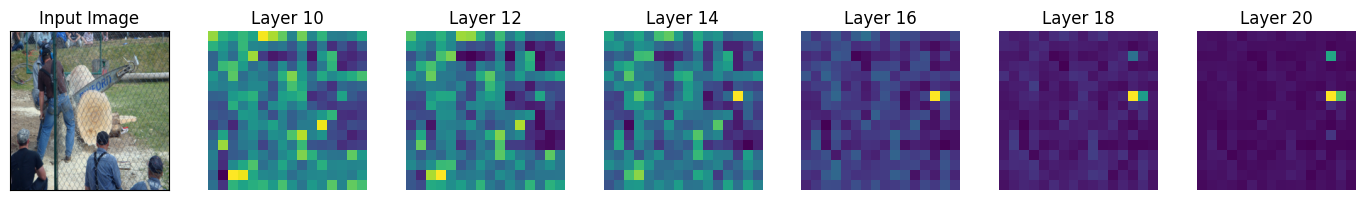

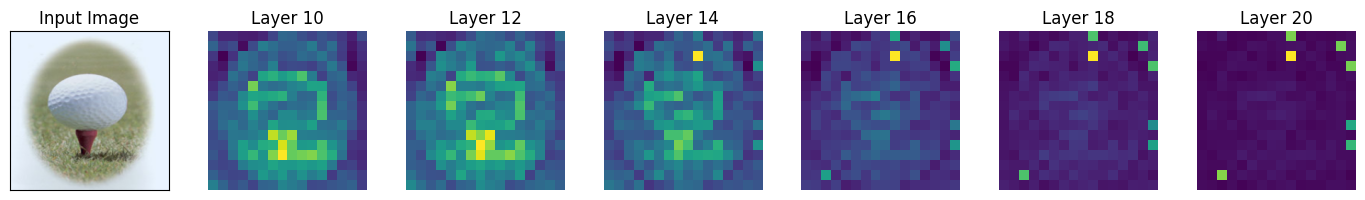

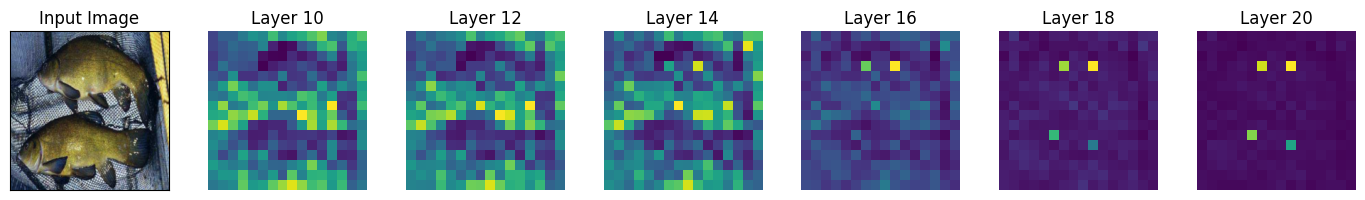

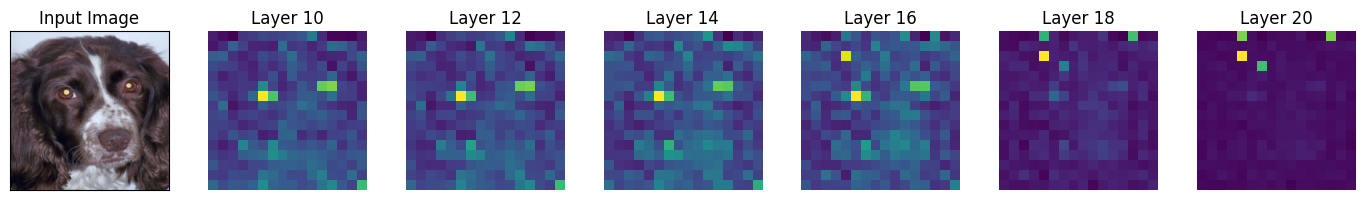

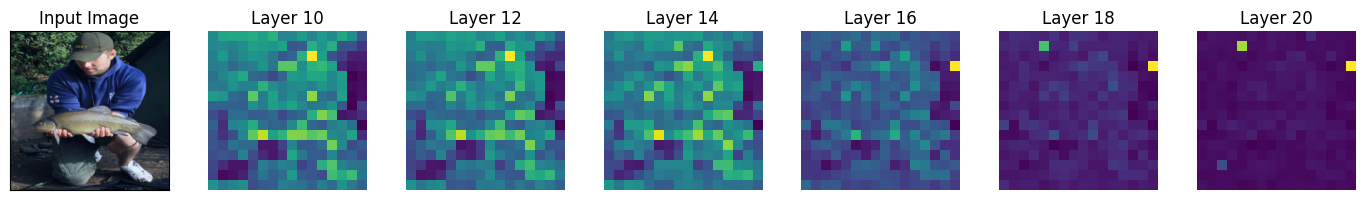

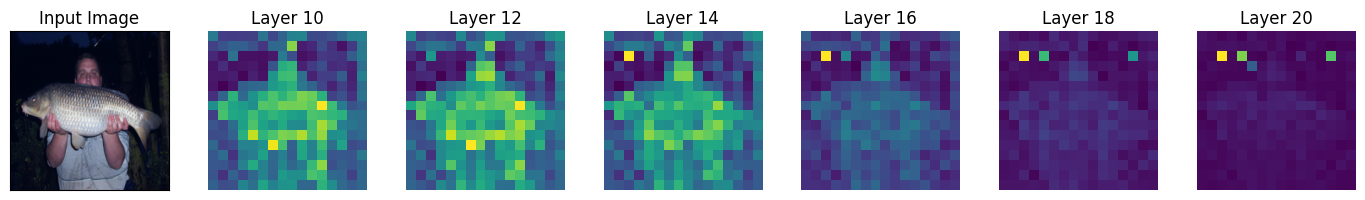

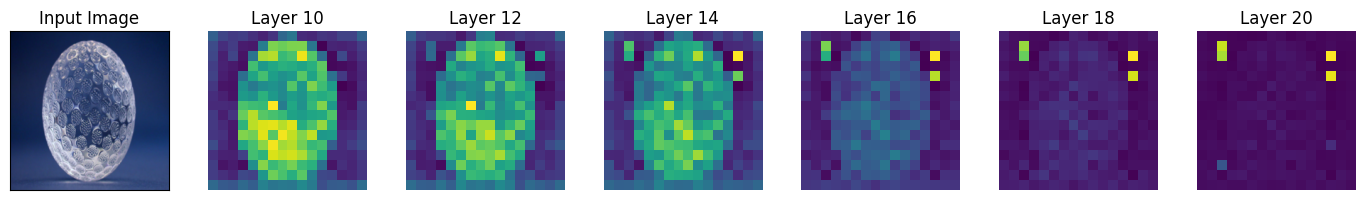

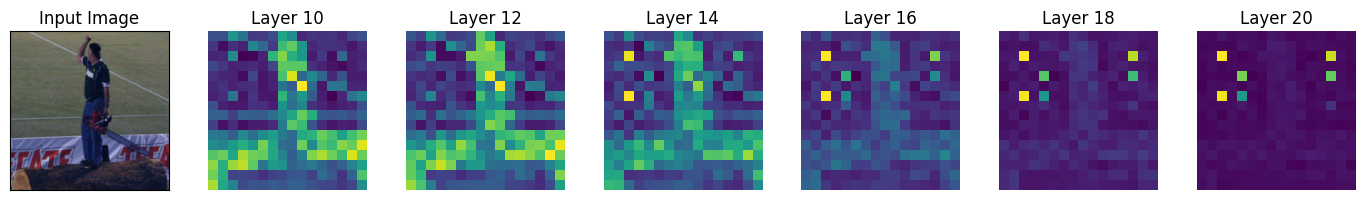

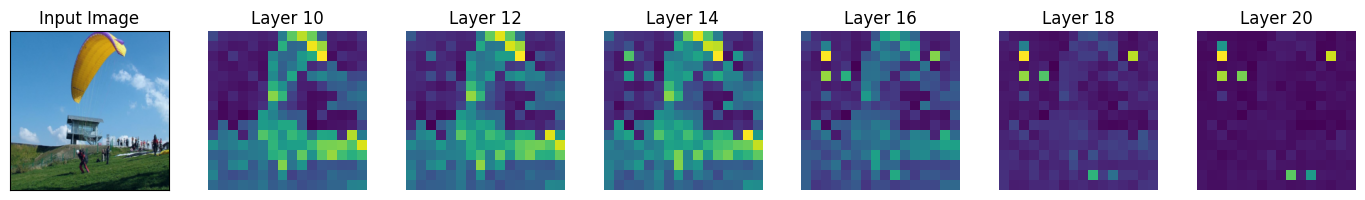

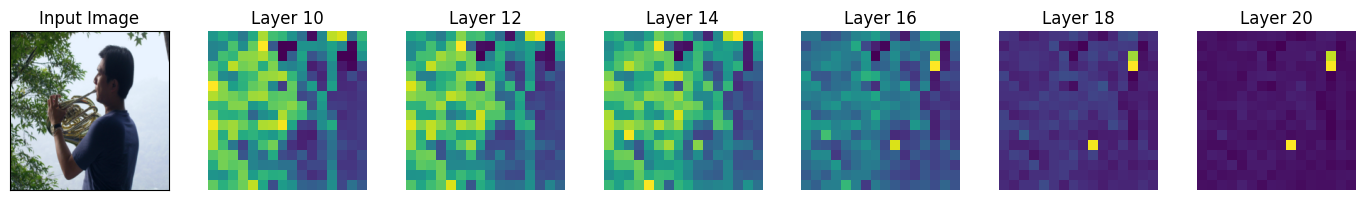

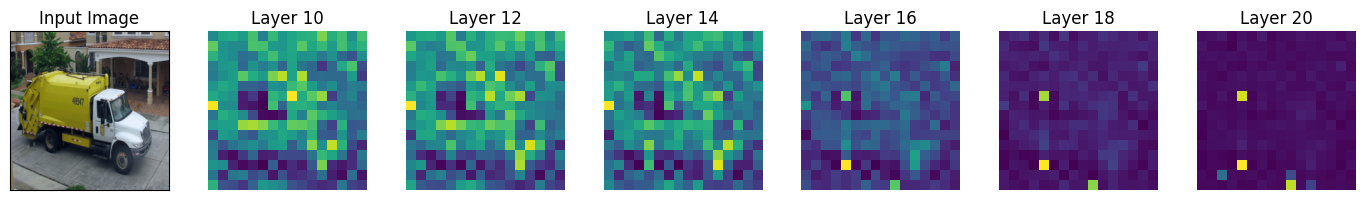

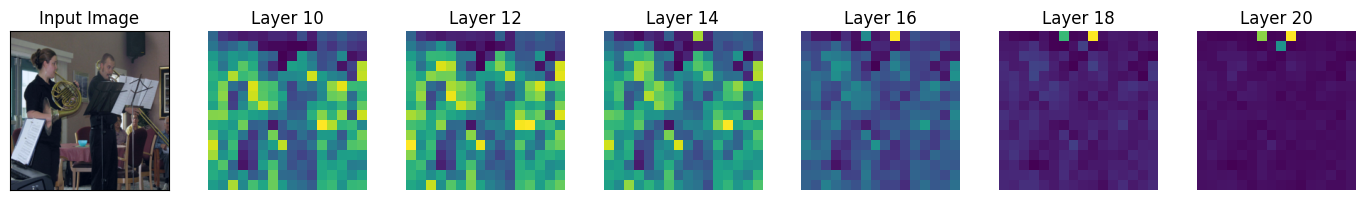

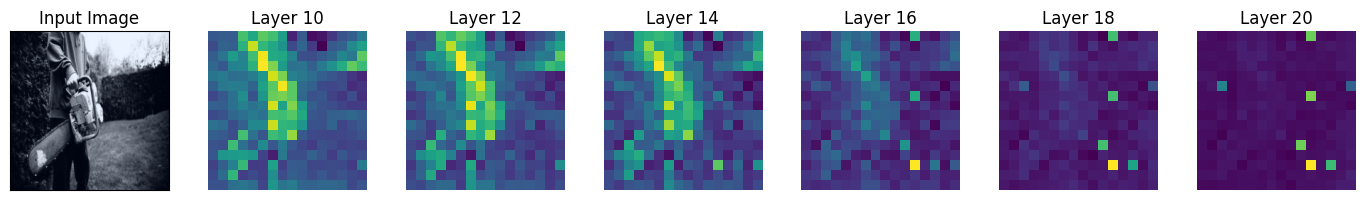

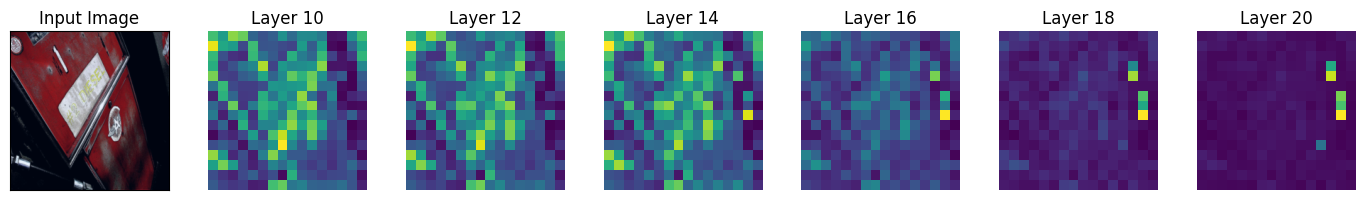

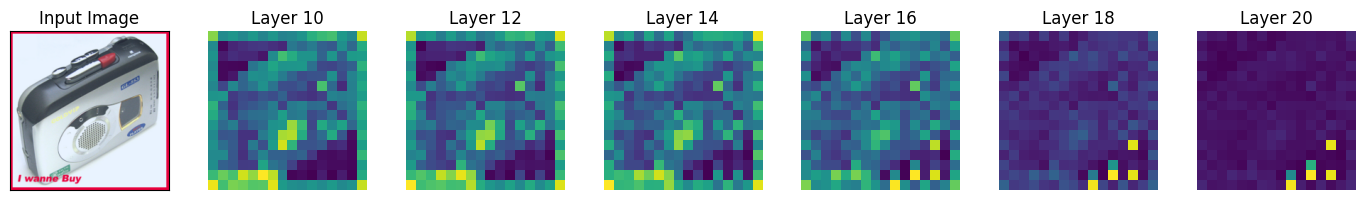

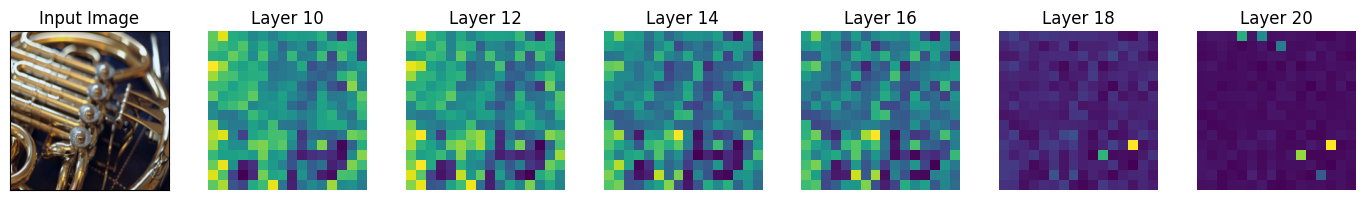

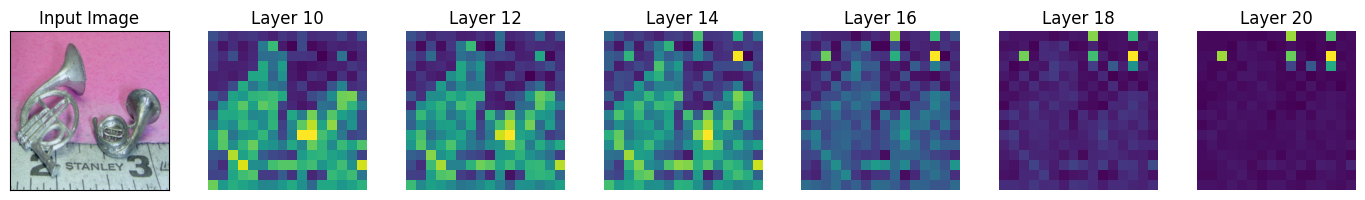

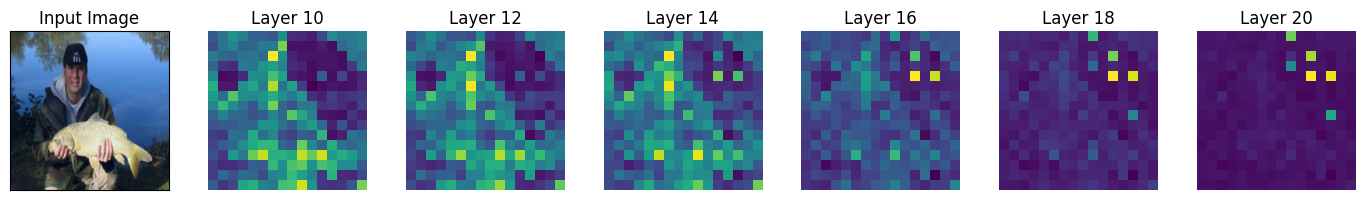

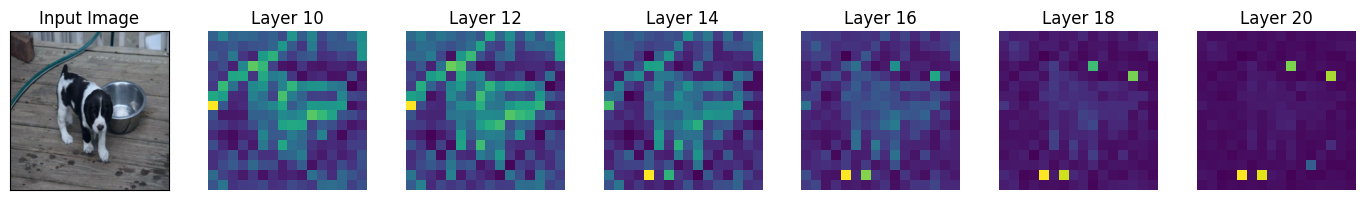

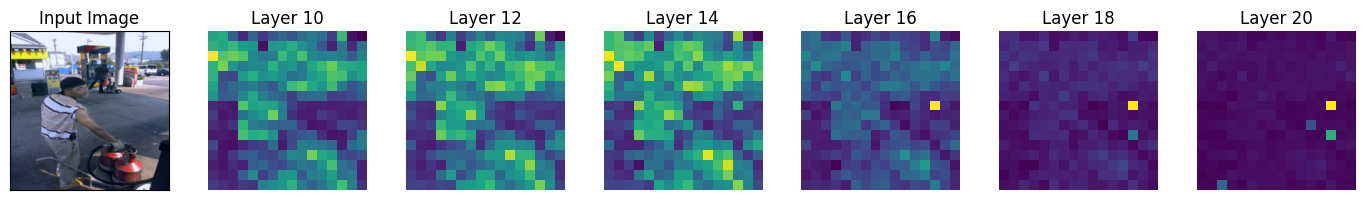

In [ ]:
for i in range(20):
  visualize_emb_att_mlp(dinov2_giant,
                        sample_images[i:i+1],
                        maps_to_visualize=["spatial_embs",],
                        layers_to_visualize=(10, 12, 14, 16, 18, 20),
                        norm_along_layers=False,
                        log_norm=False,
                        )

In [ ]:
dinov2_giant_reg.num_register_tokens

4

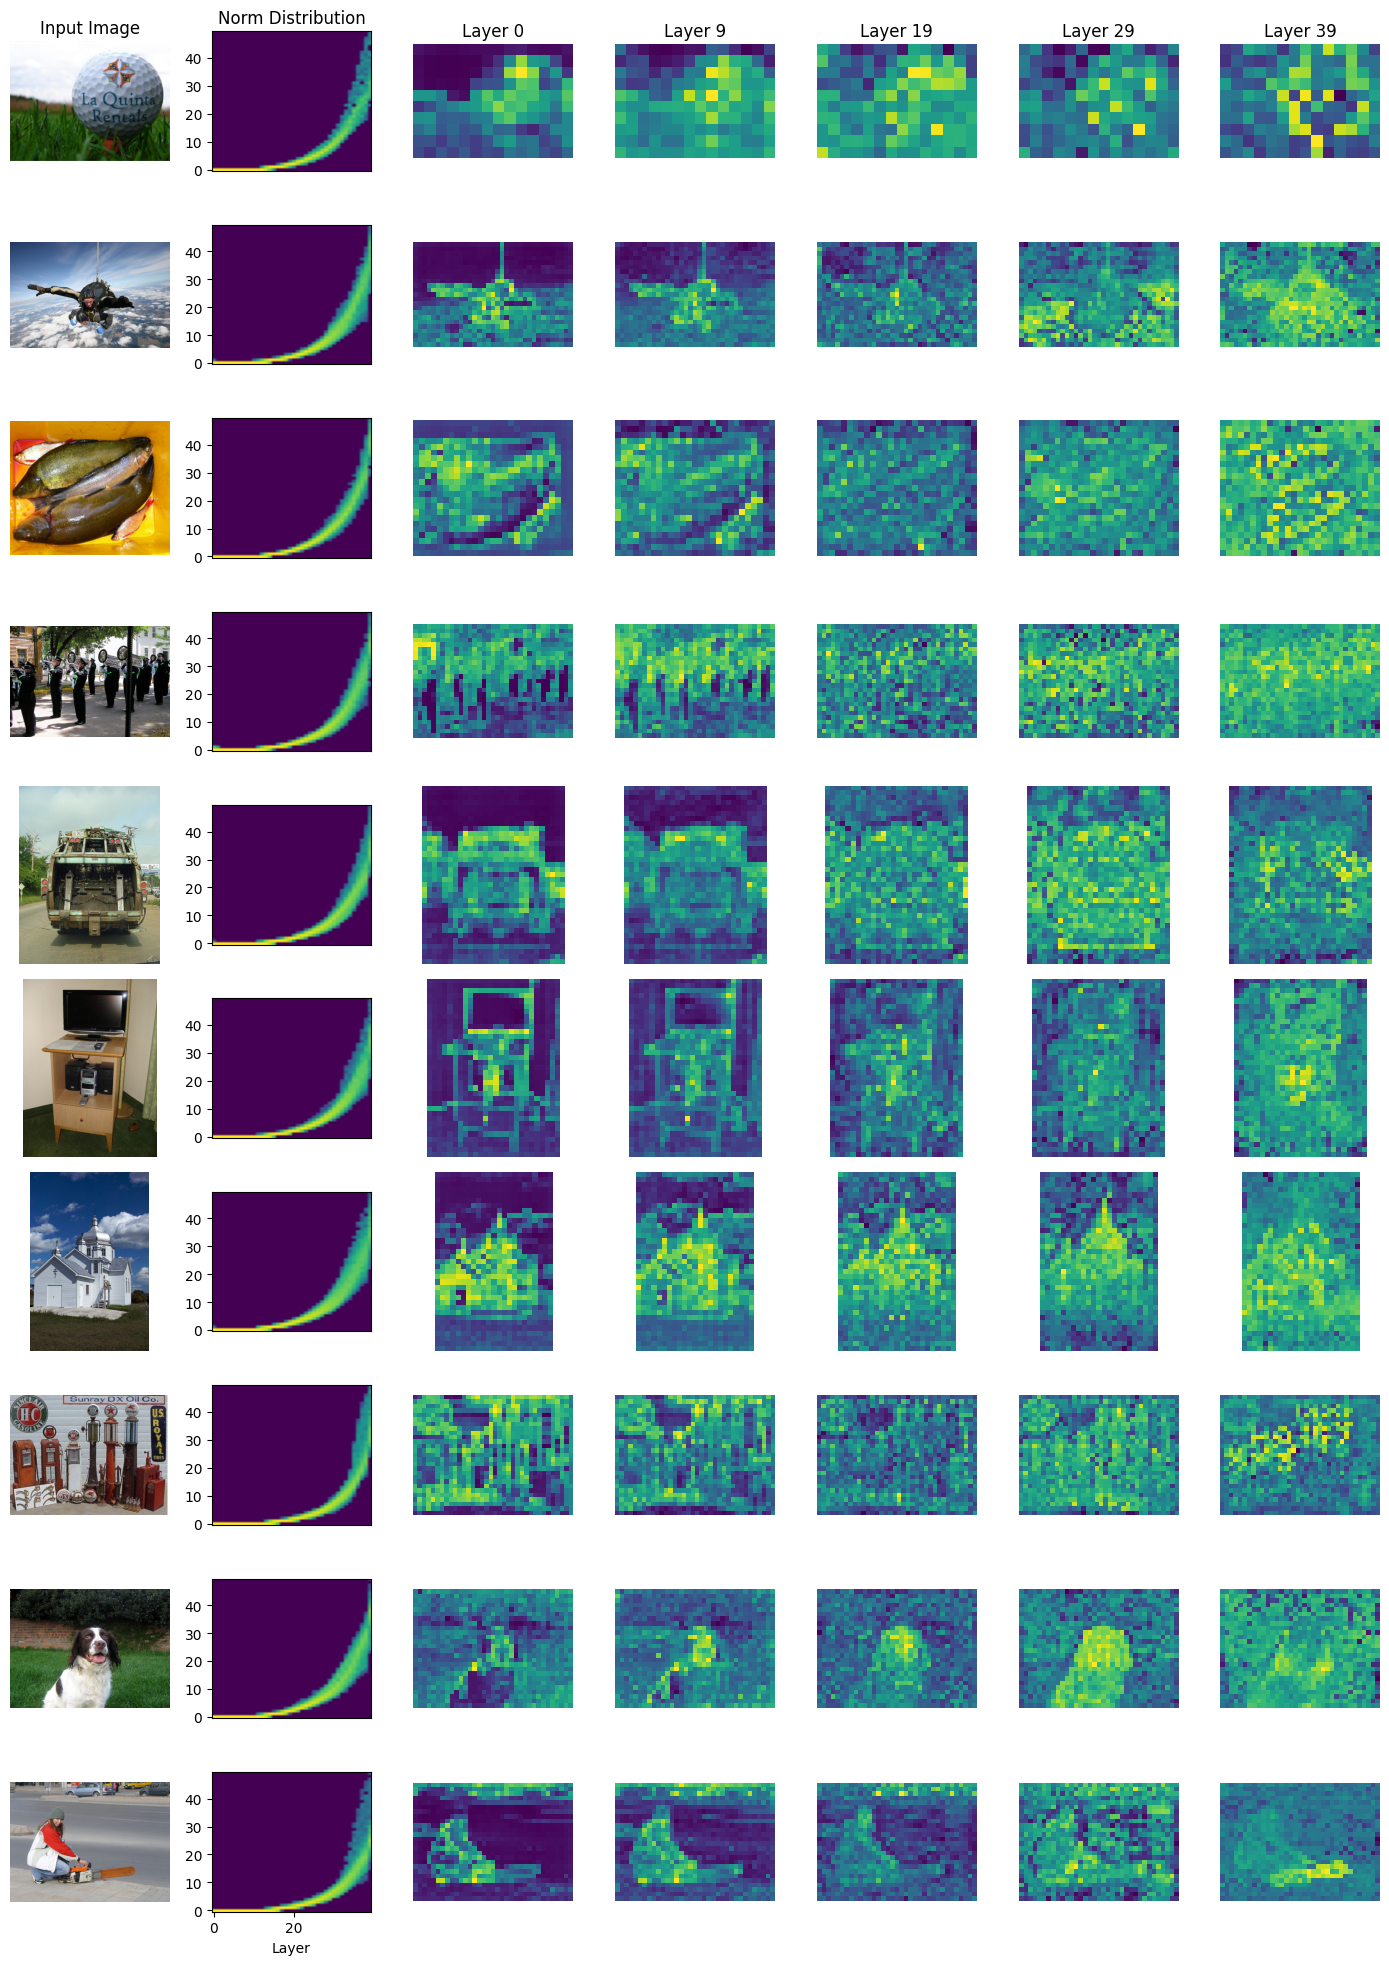

In [ ]:
visualize_normal_maps(dinov2_giant_reg,
                      sample_images[:n_samples],
                      layers_to_visualize=(0, 9, 19, 29, 39),
                      show_norms=True)

For DINOv2 large artifacts appear very suddenly in layer 17. However, looking at the normal curves reveals that the effect is mainly visual

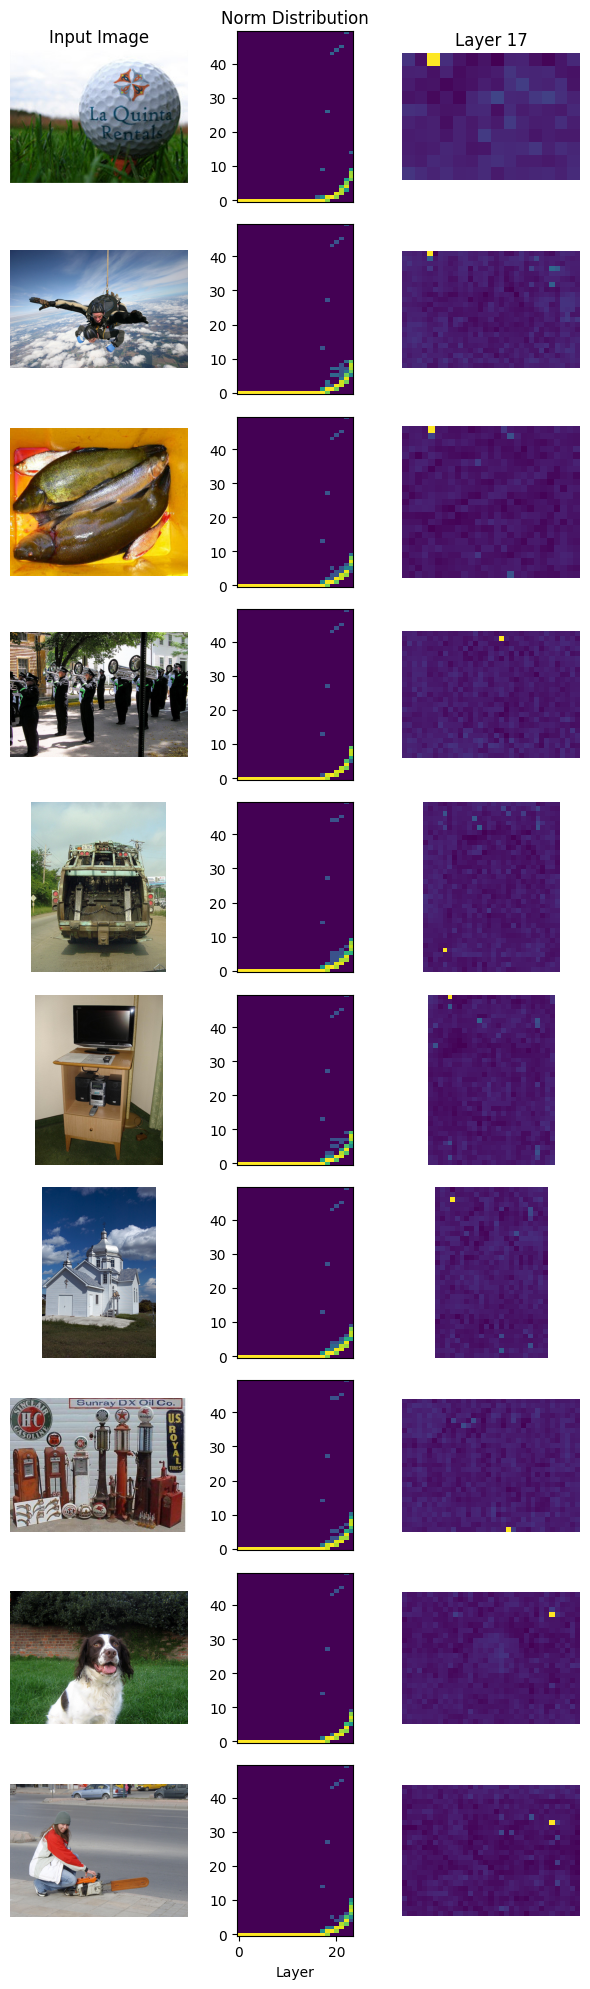

In [ ]:
visualize_normal_maps(dinov2_large,
                      sample_images[:n_samples],
                      layers_to_visualize=[17],
                      show_norms=True)

## Quantative Analysis

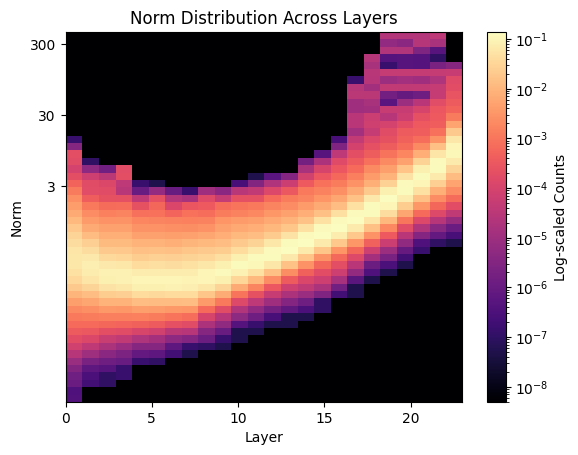

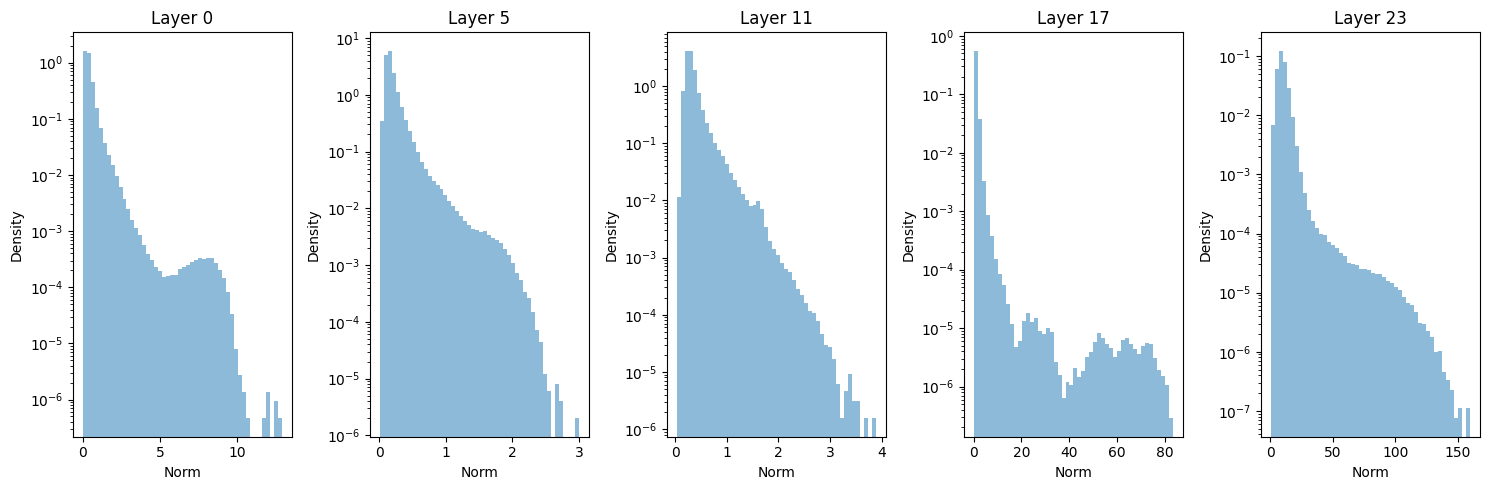

In [ ]:
visualize_average_norms(dinov2_large,
                        data_loader=data_loader,
                        n_batches=n_batches,
                        y_scale="log",
                        size=(224, 224),
                        by_layer=True,
                        layers_to_visualize=(0, 5, 11, 17, 23)
                        )

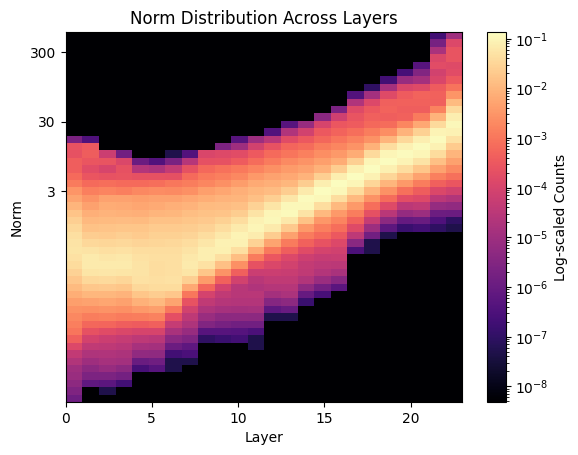

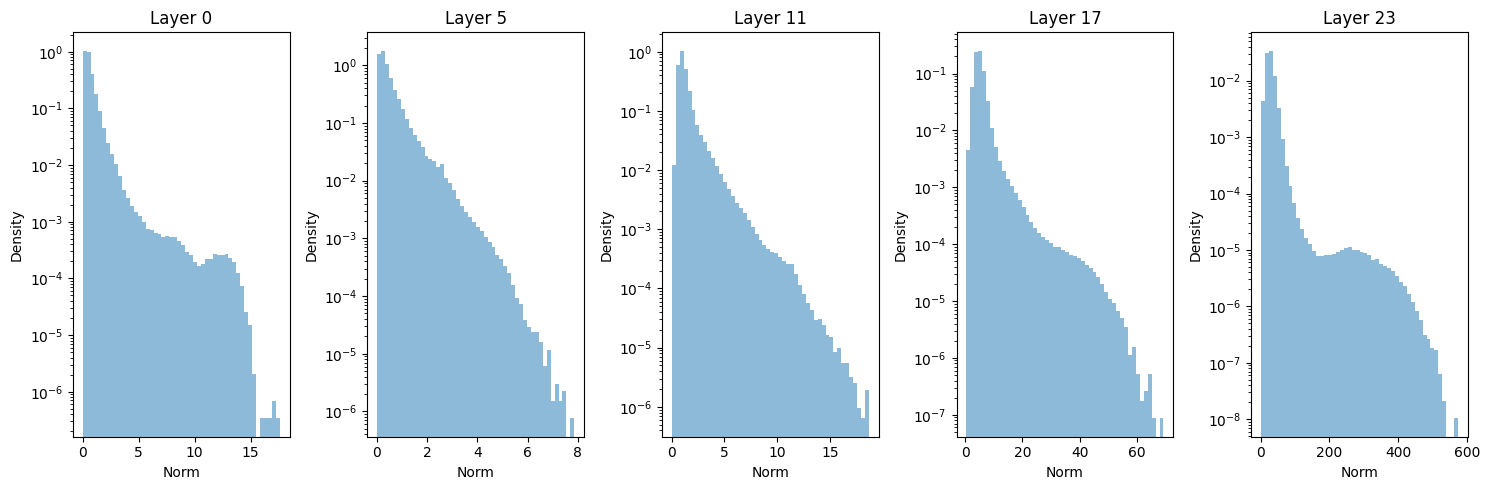

In [ ]:
visualize_average_norms(dinov2_large_reg,
                        data_loader=data_loader,
                        n_batches=n_batches,
                        y_scale="log",
                        size=(224, 224),
                        by_layer=True,
                        layers_to_visualize=(0, 5, 11, 17, 23)
                        )

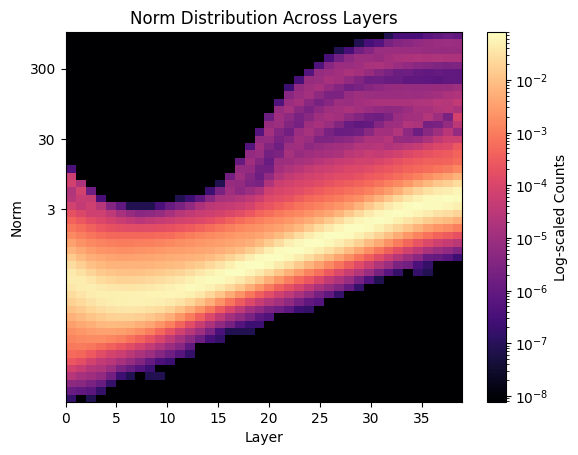

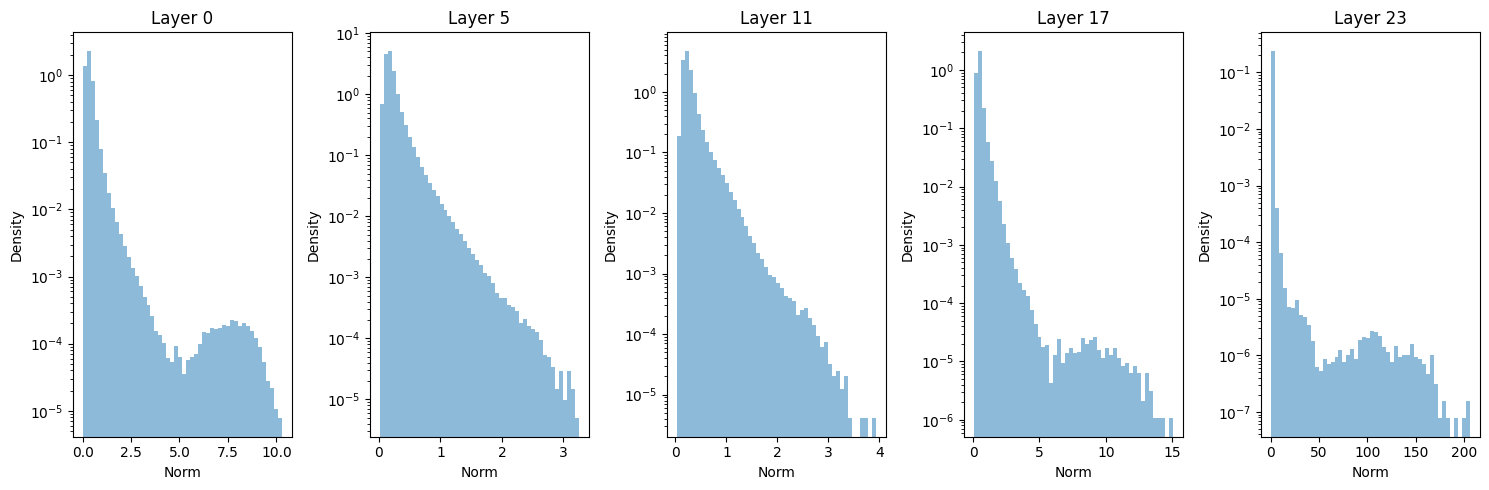

In [ ]:
visualize_average_norms(dinov2_giant,
                        data_loader=data_loader,
                        n_batches=n_batches,
                        y_scale="log",
                        size=(224, 224),
                        by_layer=True,
                        layers_to_visualize=(0, 5, 11, 17, 23)
                        )

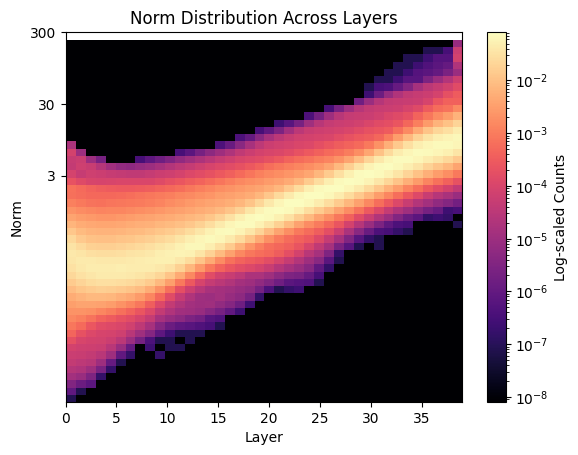

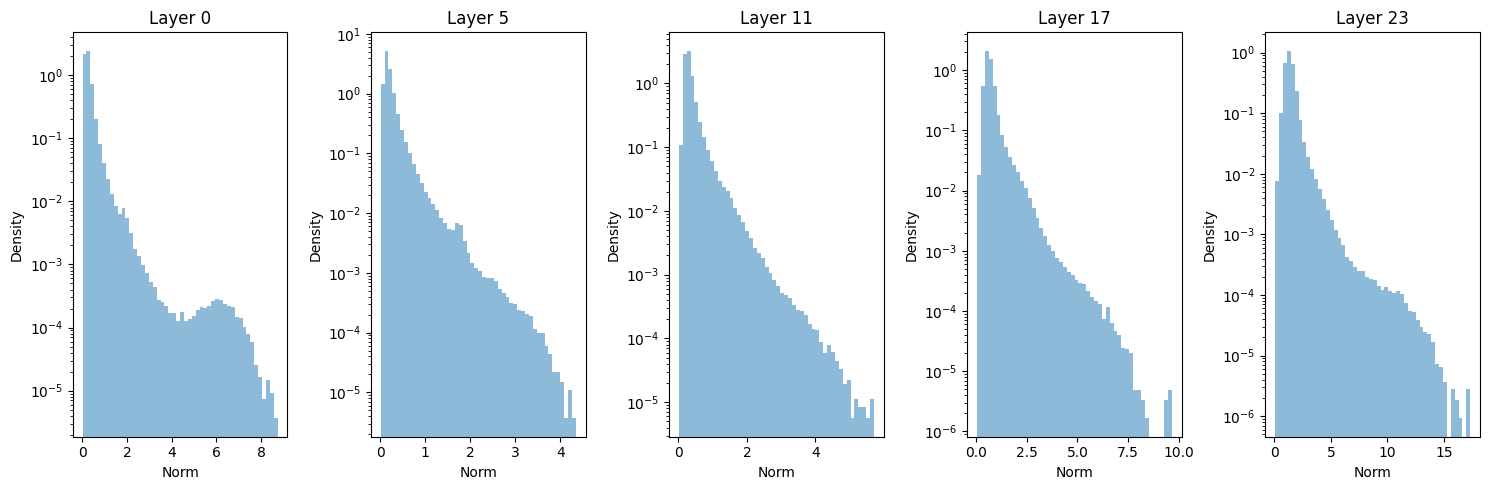

In [ ]:
visualize_average_norms(dinov2_giant_reg,
                        data_loader=data_loader,
                        n_batches=n_batches,
                        y_scale="log",
                        size=(224, 224),
                        by_layer=True,
                        layers_to_visualize=(0, 5, 11, 17, 23)
                        )

## Free up memory

In [ ]:
del dinov2_large

In [ ]:
del dinov2_large_reg

In [ ]:
del dinov2_giant

In [ ]:
del dinov2_giant_reg

In [ ]:
torch.cuda.empty_cache()

<br><br>

---

<br><br>

# DeiT III (pretrained from timm)

Code to load and evaluate DeiT III models using timm.
Visualizes individual images across layers as well as averaged norm curves.


## pick models to load

In [25]:
load_modles = "small"  # @param ['small', 'base', 'large', 'all']
trained_on = "fb_in22k_ft_in1k"  # @param ['fb_in1k', 'fb_in22k_ft_in1k']

In [ ]:
# @title DeiT custom forward

def custom_attention_forward(att_module: torch.nn.Module,
                             x: torch.Tensor
                             ) -> Tuple[torch.Tensor, torch.Tensor] | torch.Tensor:

  B, N, C = x.shape
  qkv = att_module.qkv(x).reshape(B, N, 3, att_module.num_heads, att_module.head_dim).permute(2, 0, 3, 1, 4)
  q, k, v = qkv.unbind(0)
  q, k = att_module.q_norm(q), att_module.k_norm(k)

  # x = torch.nn.functional.scaled_dot_product_attention(
  #     q, k, v,
  #     dropout_p=att_module.attn_drop.p if att_module.training else 0.,
  # )

  q = q * att_module.scale
  attn = q @ k.transpose(-2, -1)
  attn = attn.softmax(dim=-1)
  attn = att_module.attn_drop(attn)
  x = attn @ v

  x = x.transpose(1, 2).reshape(B, N, C)
  x = att_module.proj(x)
  x = att_module.proj_drop(x)

  return x, attn

def custom_block_forward(block: timm.models.vision_transformer.Block,
                         x: torch.Tensor
                         ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:

  att_, att = custom_attention_forward(block.attn, block.norm1(x))
  # att has shape 1 (batch), 6 (attention heads), 197 (respective token), 197 (respective tokens attentions to each token, sums to 1);
  # print(att[0, 0, 0].sum())
  # take mean over attention heads
  att = att.mean(dim=1)
  att_ = block.drop_path1(block.ls1(att_))
  # att = block.drop_path1(block.ls1(block.attn(block.norm1(x))))
  x = x + att_
  mlp = block.drop_path2(block.ls2(block.mlp(block.norm2(x))))
  x = x + mlp
  return x, att, mlp

def custom_forward(
            model,
            x: torch.Tensor,
            indices: Optional[Union[int, List[int]]] = None,
            return_prefix_tokens: bool = False,
            stop_early: bool = False,
            output_fmt: str = 'NCHW',
            intermediates_only: bool = False,
            return_att_mlp: bool = False
    ) -> Any:
  """ Forward features that returns intermediates.

  Args:
      x: Input image tensor
      indices: Take last n blocks if int, all if None, select matching indices if sequence
      return_prefix_tokens: Return both prefix and spatial intermediate tokens
      norm: Apply norm layer to all intermediates
      stop_early: Stop iterating over blocks when last desired intermediate hit
      output_fmt: Shape of intermediate feature outputs
      intermediates_only: Only return intermediate features
      return_att_mlp: Return attention and MLP outputs seperately
  Returns:
      List of intermediate features, optionally with attention and MLP outputs
  """
  assert output_fmt in ('NCHW', 'NLC'), 'Output format must be one of NCHW or NLC.'
  reshape = output_fmt == 'NCHW'
  intermediates = []
  spatial_atts = []
  spatial_mlps = []
  take_indices, max_index = feature_take_indices(len(model.blocks), indices)

  # forward pass
  B, _, height, width = x.shape
  x = model.patch_embed(x)
  x = model._pos_embed(x)
  x = model.patch_drop(x)
  x = model.norm_pre(x)

  if torch.jit.is_scripting() or not stop_early:  # can't slice blocks in torchscript
    blocks = model.blocks
  else:
    blocks = model.blocks[:max_index + 1]
  for i, blk in enumerate(blocks):
    x, att, mlp = custom_block_forward(blk, x)
    if i in take_indices:
      # normalize intermediates with final norm layer if enabled
      intermediates.append(x)
      spatial_atts.append(att)
      spatial_mlps.append(mlp)

  # process intermediates
  if model.num_prefix_tokens:
    # split prefix (e.g. class, distill) and spatial feature tokens
    prefix_tokens = [y[:, 0:model.num_prefix_tokens] for y in intermediates]
    intermediates = [y[:, model.num_prefix_tokens:] for y in intermediates]
    prefix_att = [y[:, 0:model.num_prefix_tokens] for y in spatial_atts]
    spatial_atts = [y[:, model.num_prefix_tokens:] for y in spatial_atts]
    prefix_mlp = [y[:, 0:model.num_prefix_tokens] for y in spatial_mlps]
    spatial_mlps = [y[:, model.num_prefix_tokens:] for y in spatial_mlps]

  # reshape to BHWC output format
  H, W = model.patch_embed.dynamic_feat_size((height, width))
  intermediates = [y.reshape(B, H, W, -1).contiguous() for y in intermediates]
  spatial_atts = [y.reshape(B, H, W, -1).contiguous() for y in spatial_atts]
  spatial_mlps = [y.reshape(B, H, W, -1).contiguous() for y in spatial_mlps]
  if return_prefix_tokens:
    prefix_att = [y[:, :, model.num_prefix_tokens:].reshape(B, H, W, -1).contiguous() for y in prefix_att]

  x = model.norm(x)
  out = list()
  if not intermediates_only:
    out.append(x)
  out.append(intermediates)
  if return_att_mlp:
    out.append(spatial_atts)
    out.append(spatial_mlps)
  if model.num_prefix_tokens and return_prefix_tokens:
    out.append(prefix_att)

  return tuple(out)

## Load Models

In [ ]:
# @title Load Small
deit_small = timm.create_model(f'deit3_small_patch16_224.{trained_on}', pretrained=True)
deit_small.eval();

In [ ]:
# @title Load Base
if load_modles in ["base", "large", "huge"]:
  deit_base = timm.create_model(f'deit3_base_patch16_224.{trained_on}', pretrained=True)
  deit_base.eval();
else:
  deit_base = None

In [ ]:
# @title Load Large
if load_modles in ["large", "huge"]:
  deit_large = timm.create_model(f'deit3_large_patch16_224.{trained_on}', pretrained=True)
  deit_large.eval();
else:
  deit_large = None

In [ ]:
# @title Load Huge
if load_modles == "huge":
  deit_huge = timm.create_model(f'deit3_huge_patch16_224.{trained_on}', pretrained=True)
  deit_huge.eval();
else:
  deit_huge = None

In [ ]:
# @title Print Model Info
print(len(deit_small.blocks))
print(len(deit_base.blocks)) if deit_base else None
print(len(deit_large.blocks)) if deit_large else None
print(len(deit_huge.blocks)) if deit_huge else None
print(deit_small.patch_embed.num_patches)
print(deit_base.patch_embed.num_patches) if deit_base else None
print(deit_large.patch_embed.num_patches) if deit_large else None
print(deit_huge.patch_embed.num_patches) if deit_huge else None

12
12
196
196


## Qualitative Analysis

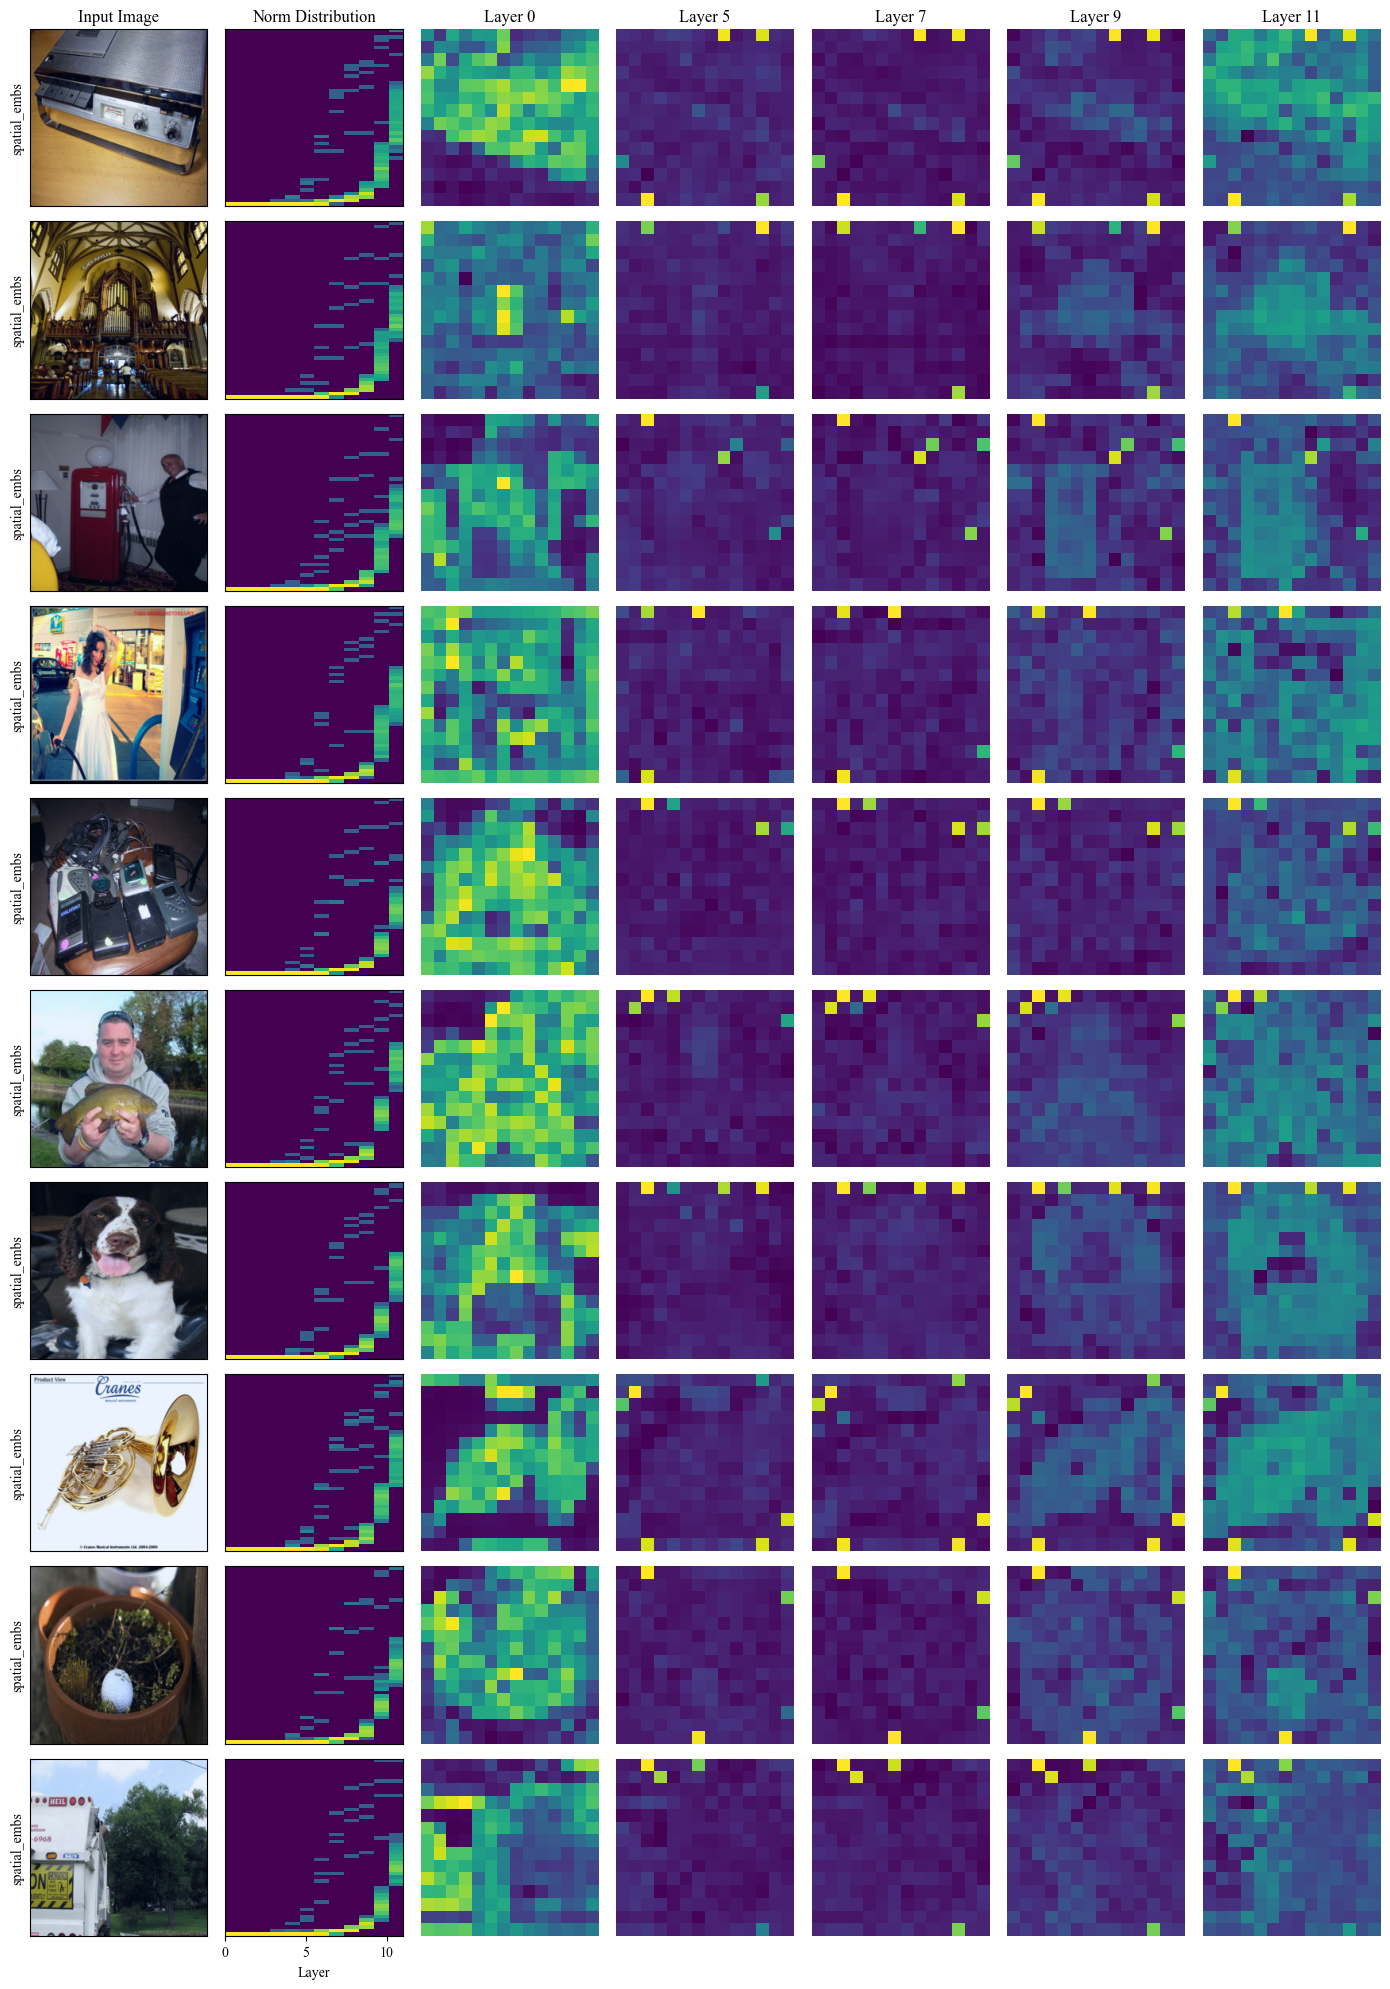

In [ ]:
visualize_emb_att_mlp(model=deit_small,
                      images=sample,
                      layers_to_visualize=(0, 5, 7, 9, 11),
                      maps_to_visualize=["spatial_embs",],
                      size=(224, 224),
                      show_norms=True,
)

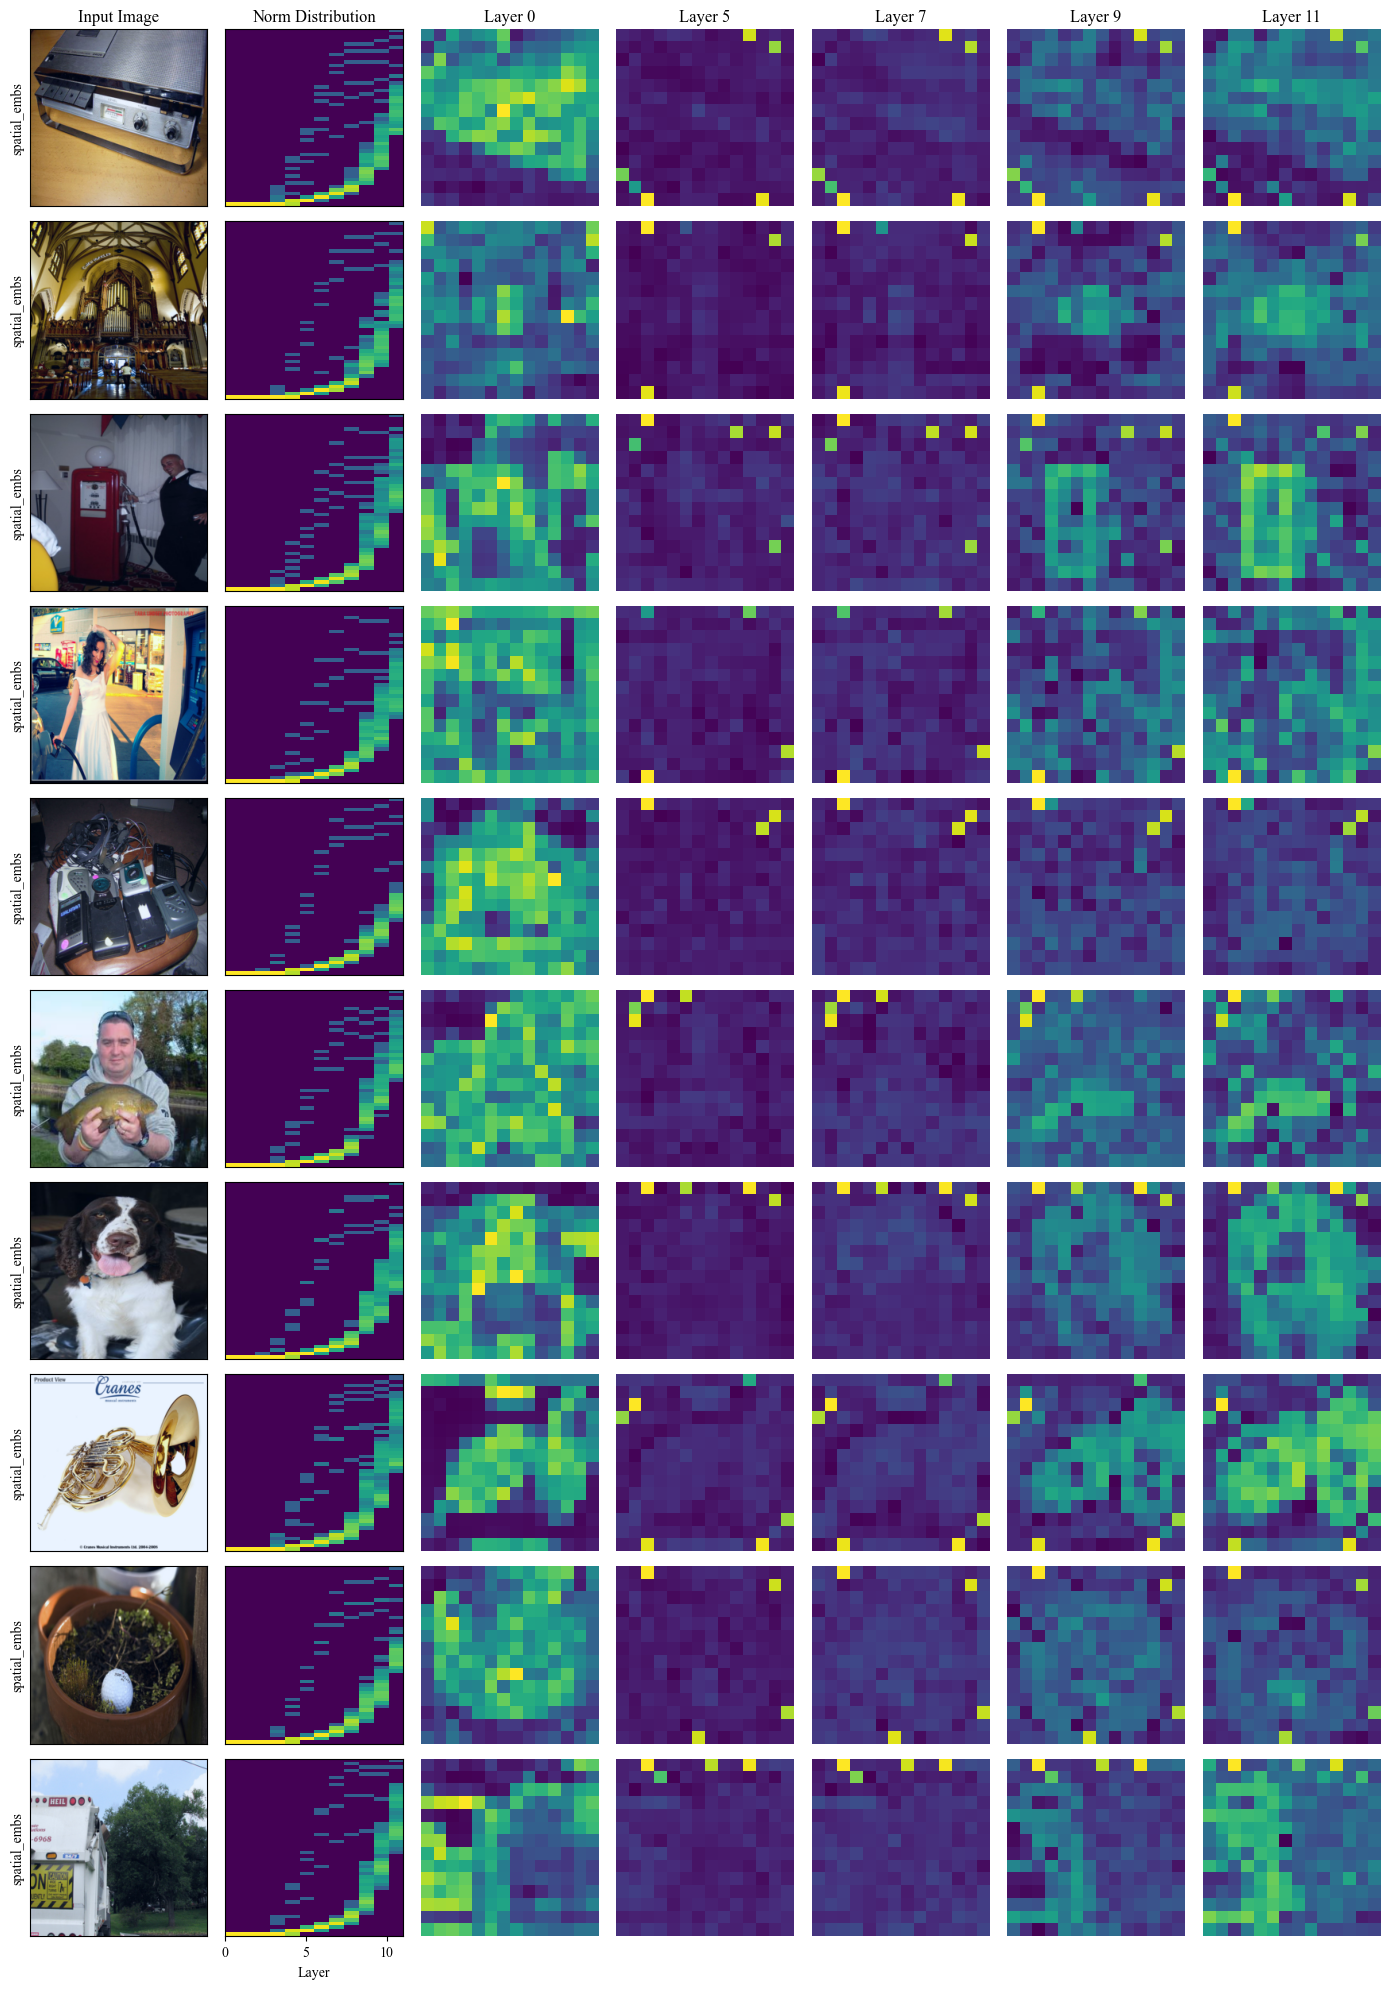

In [ ]:
visualize_emb_att_mlp(model=deit_base,
                      images=sample,
                      layers_to_visualize=(0, 5, 7, 9, 11),
                      size=(224, 224),
                      maps_to_visualize=["spatial_embs",],
                      show_norms=True,
)

In [ ]:
visualize_emb_att_mlp(model=deit_large,
                      images=sample,
                      layers_to_visualize=(0, 6, 15, 19, 23),
                      maps_to_visualize=["spatial_embs",],
                      size=(224, 224),
                      show_norms=True,
)

In [ ]:
visualize_emb_att_mlp(model=deit_huge,
                      images=sample_images,
                      layers_to_visualize=(0, 6, 15, 19, 23),
                      maps_to_visualize=["spatial_embs",],
                      size=(224, 224),
                      show_norms=True,
)


## Quantitative Analysis

In [ ]:
n_batches = 8




spatial_embs


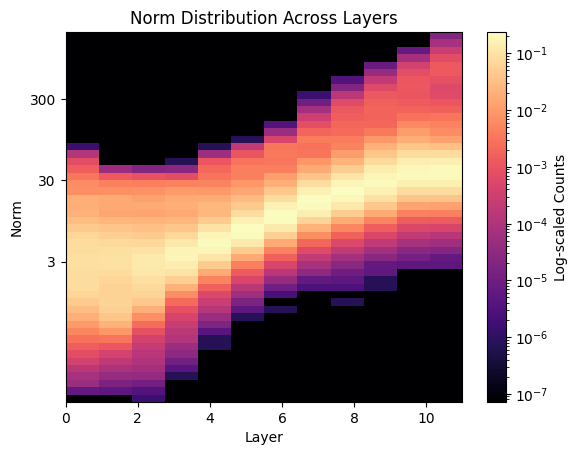

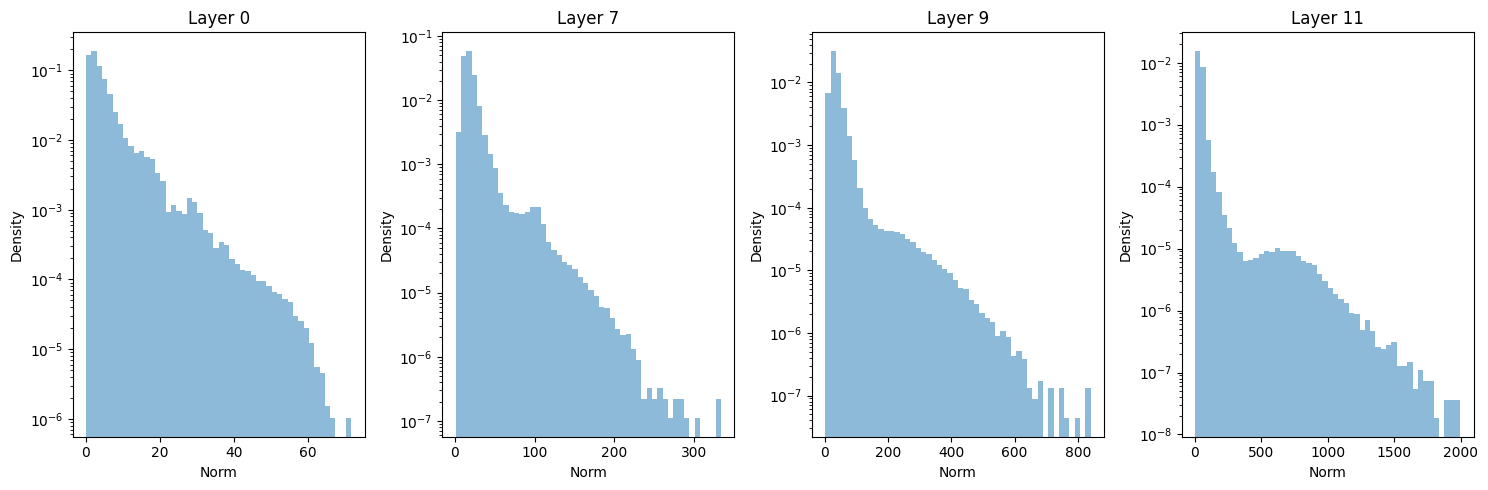

In [ ]:
visualize_average_norms(model=deit_small,
                        data_loader=data_loader,
                        n_batches=n_batches,
                        layers_total=12,
                        y_scale="log",
                        size=(224, 224),
                        by_layer=True,
                        layers_to_visualize=(0, 7, 9, 11),
                        norm_scale="log",
                        density_scale="log",
                        )




spatial_embs


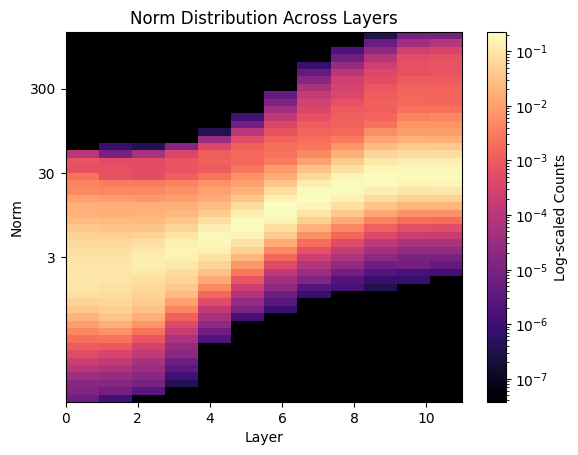

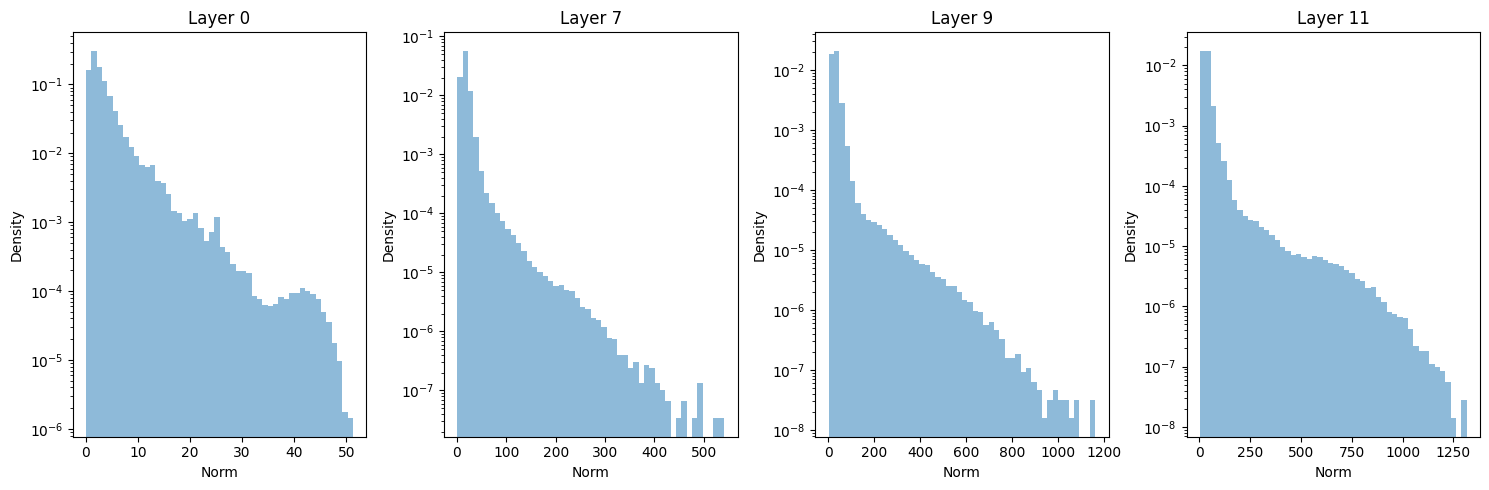

In [ ]:
visualize_average_norms(model=deit_base,
                        data_loader=data_loader,
                        n_batches=n_batches,
                        layers_total=12,
                        size=(224, 224),
                        by_layer=True,
                        layers_to_visualize=(0, 7, 9, 11),
                        norm_scale="log",
                        density_scale="log",
                        )

In [ ]:
visualize_average_norms(model=deit_large,
                        data_loader=data_loader,
                        n_batches=n_batches,
                        layers_total=12,
                        size=(224, 224),
                        by_layer=True,
                        layers_to_visualize=(0, 7, 9, 11)
                        )

In [ ]:
visualize_average_norms(model=deit_huge,
                        image_batches=data_loader,
                        layers_total=12,
                        size=(224, 224),
                        by_layer=True,
                        layers_to_visualize=(0, 7, 9, 11)
                        )

NameError: name 'sample_images_batched' is not defined

<br><br>

---

<br><br>

# DeiT III (Ours)

Code to load and evaluate checkpoints of our DeiTII models with and without registers, requires access to checkpoint files.
Visualizes individual images across layers as well as averaged norm curves.

In [ ]:
checkpoint_name = "checkpoint799.pth"

deit_source = load_models_from_drive(checkpoint_name, registers=False)
deit_register = load_models_from_drive(checkpoint_name, registers=True)


<ipython-input-14-875f458ee796>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODELS_PATH[path] + "/" + checkpoint_name,


## Qualitative Analysis (Visualization of individual images)

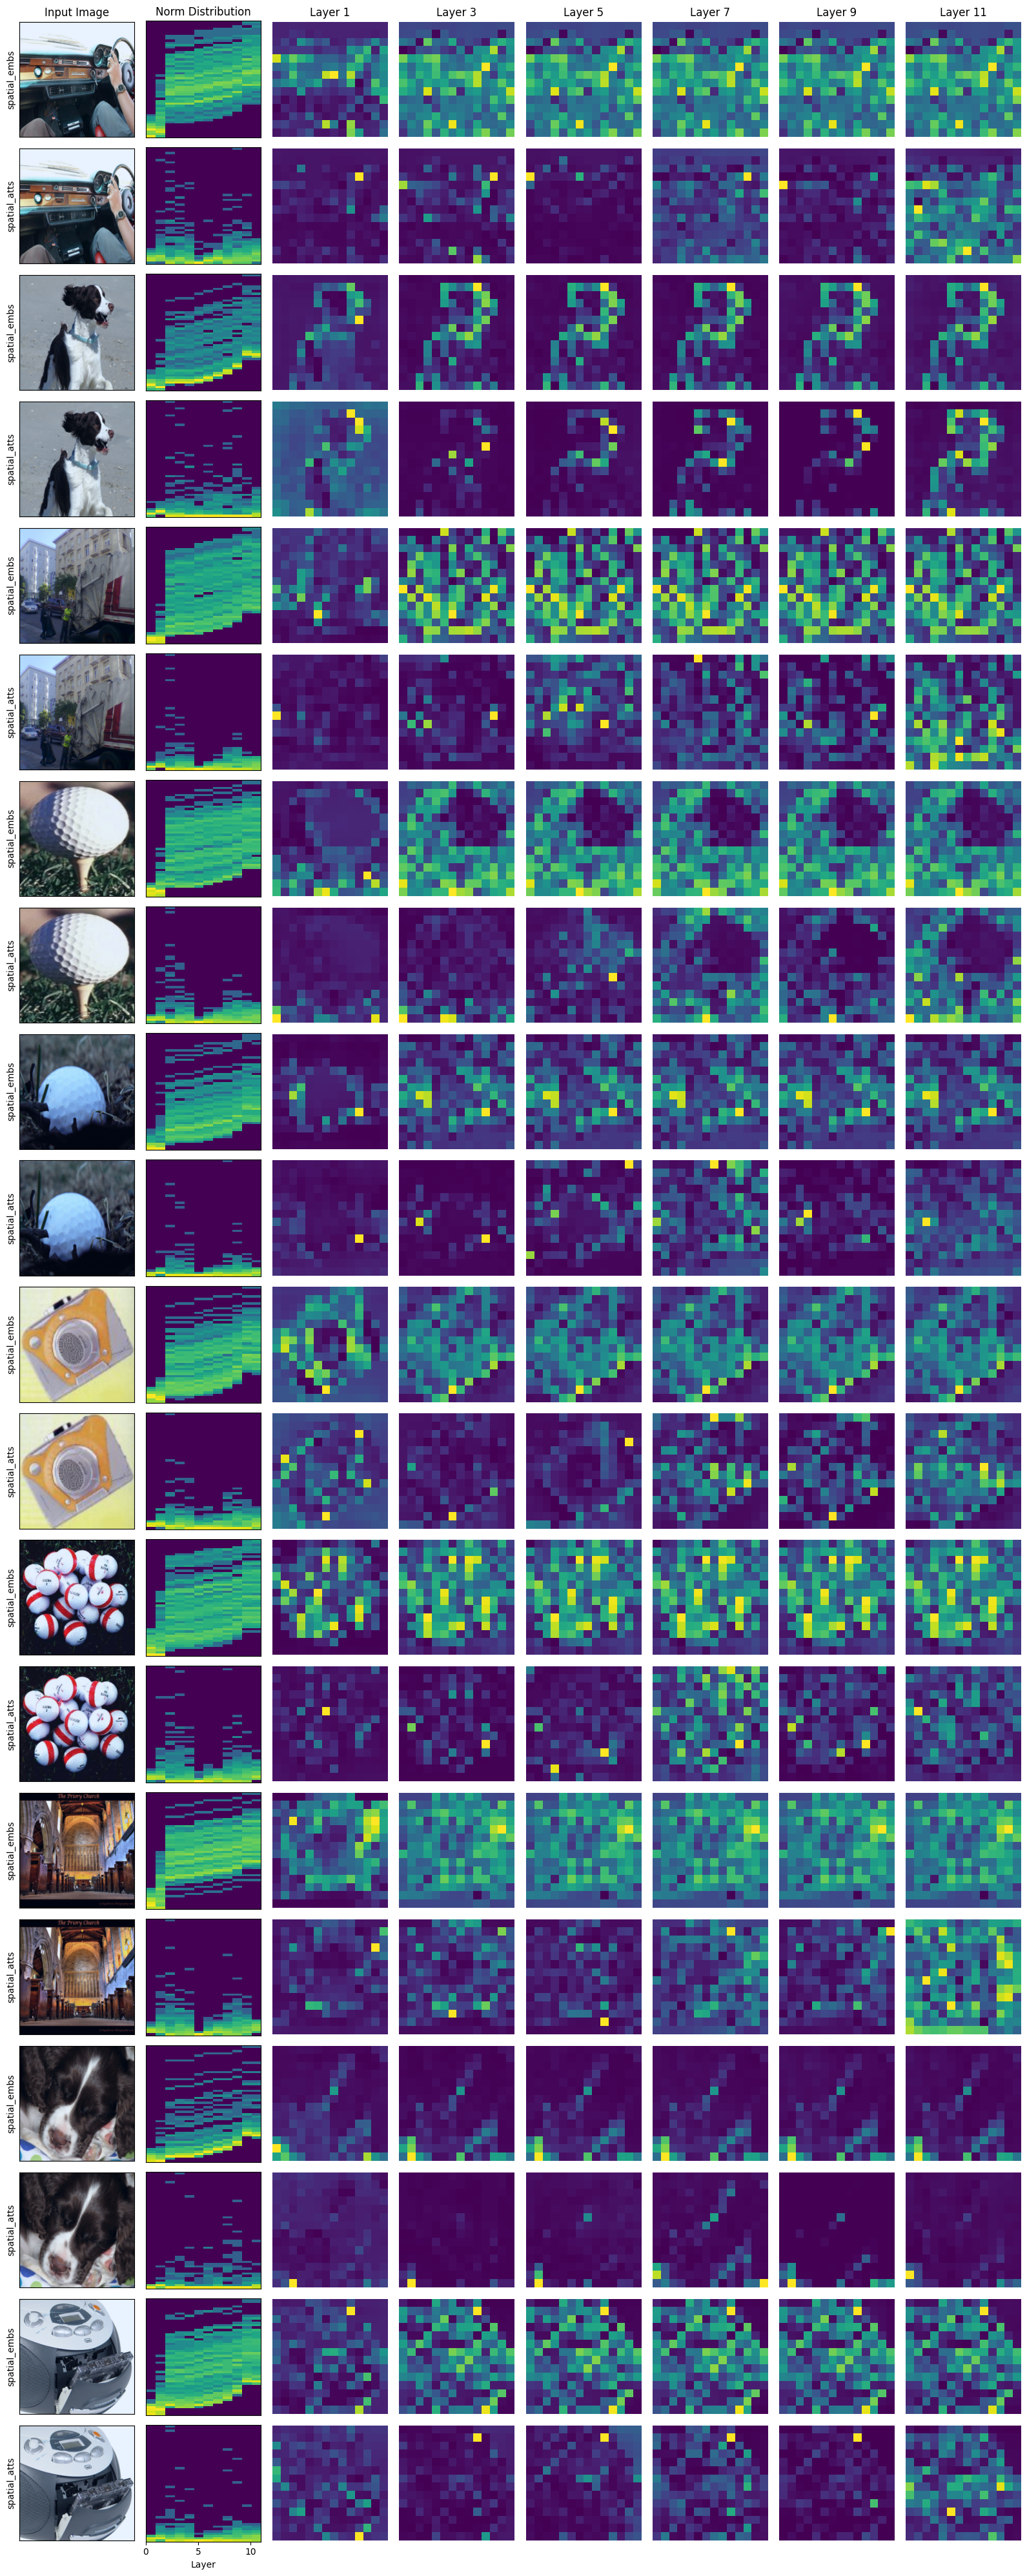

In [ ]:
visualize_emb_att_mlp(model=deit_source,
                      images=sample,
                      layers_to_visualize=(1, 3, 5, 7, 9, 11),
                      maps_to_visualize=[
                          "spatial_embs",
                          "spatial_atts",
                      ],
                      log_norm=False
                      )

In [ ]:
visualize_emb_att_mlp(model=deit_register,
                      images=sample,
                      layers_to_visualize=(0, 5, 7, 9, 11),
                      maps_to_visualize=[
                          "spatial_embs",
                          "spatial_atts",
                      ],
                      size=(224, 224),
                      show_norms=True,
                      )

In [ ]:
visualize_emb_att_mlp(model=deit_register,
                      images=sample,
                      layers_to_visualize=[11,],
                      maps_to_visualize=[
                          "prefix_atts",
                      ],
                      size=(224, 224),
                      show_norms=True,
                      )

In [ ]:
deit_register = load_models_from_drive("checkpoint399.pth", registers=True)
visualize_emb_att_mlp(model=deit_register,
                      images=sample[:5],
                      layers_to_visualize=[11,],
                      maps_to_visualize=[
                          "prefix_atts",
                      ],
                      size=(224, 224),
                      show_norms=True,
                      )

In [ ]:
deit_register = load_models_from_drive("checkpoint19.pth", registers=True)
visualize_emb_att_mlp(model=deit_register,
                      images=sample[:5],
                      layers_to_visualize=[11,],
                      maps_to_visualize=[
                          "prefix_atts",
                      ],
                      size=(224, 224),
                      show_norms=True,
                      )

## Quantitative Analysis

In [ ]:
visualize_average_norms(deit_source,
                        data_loader=data_loader,
                        n_batches=len(data_loader),
                        by_layer=True,
                        layers_to_visualize=(0, 5, 7, 9, 11),
                        maps_to_visualize=["spatial_embs", "spatial_atts"],
                        size=(224, 224),
                        density_scale="log",
                       )


In [ ]:
visualize_average_norms(deit_register,
                        data_loader=data_loader,
                        n_batches=len(data_loader),
                        by_layer=True,
                        layers_to_visualize=(0, 5, 7, 9, 11),
                        maps_to_visualize=["spatial_embs", "spatial_atts"],
                        size=(224, 224),
                        density_scale="log",
                       )


In [ ]:
visualize_average_norms(deit_register,
                        data_loader=data_loader,
                        n_batches=len(data_loader),
                        by_layer=True,
                        layers_to_visualize=[11],
                        maps_to_visualize=["prefix_atts"],
                        size=(224, 224),
                        density_scale="log",
                       )

In [ ]:
visualize_average_norms(deit_register,
                        data_loader=data_loader_CIFAR10,
                        n_batches=len(data_loader_CIFAR10),
                        by_layer=True,
                        layers_to_visualize=[11],
                        maps_to_visualize=["prefix_atts"],
                        size=(224, 224),
                        density_scale="log",
                       )

In [ ]:
visualize_average_norms(deit_register,
                        data_loader=data_loader_Caltech101,
                        n_batches=len(data_loader_Caltech101),
                        by_layer=True,
                        layers_to_visualize=[11],
                        maps_to_visualize=["prefix_atts"],
                        size=(224, 224),
                        density_scale="log",
                       )

In [ ]:
visualize_average_norms(deit_register,
                        data_loader=data_loader_Flowers102,
                        n_batches=len(data_loader_Flowers102),
                        by_layer=True,
                        layers_to_visualize=[11],
                        maps_to_visualize=["prefix_atts"],
                        size=(224, 224),
                        density_scale="log",
                       )

<br><br>

---

<br><br>

# Experiment: Norms along iterations

Visualize Norm Distributions across training Epochs.
This experiment requires checkpoints every couple of training iterations.
Some properties of the plots (like log scaling) can be customized.

In [ ]:
# @title Visualize Norm Distributions for multiple model checkpoints
def visualize_along_iterations(checkpoints,
                               data_loader,
                               registers: bool,
                               maps_to_visualize: Sequence[str],
                               layers_to_visualize: Sequence[int],
                               layers_total: int,
                               n_batches: int = 32,
                               model_batch_size: int = 1,  # Number of models to evaluate simultaneously
                               **kwargs):

  for m in maps_to_visualize:
    if m not in VALID_MAPS:
      raise ValueError(f"maps_to_visualize must be one of {VALID_MAPS}")
    if m.startswith("prefix"):
      raise ValueError("Prefix token maps not supported yet")

  assert all([checkpoint_name in os.listdir(MODELS_PATH["registers" if registers else "source"])
    for checkpoint_name in checkpoints])

  truncate_norms = kwargs.get("truncate_norms", None)
  norm_scale = kwargs.get("norm_scale", "log")
  norms_dict = {map: [[[] for _ in checkpoints]
                  for _ in layers_to_visualize]
                for map in maps_to_visualize}

  # Process models in batches
  for model_start_idx in range(0, len(checkpoints), model_batch_size):
    model_end_idx = min(model_start_idx + model_batch_size, len(checkpoints))
    model_batch = checkpoints[model_start_idx:model_end_idx]

    # Load a subset of models
    models = [load_models_from_drive(cp, registers=registers).to(device) for cp in model_batch]

    # Evaluate models over multiple batches
    for n, (images, _) in enumerate(data_loader):
      if n == n_batches:
        break
      images = images.to(device)

      for n_cp, model in enumerate(models):
        output = get_all_intermediates(model, images, layers_total)

        for map in maps_to_visualize:
          for n_layer, layer in enumerate(layers_to_visualize):

            norms = output[map][layer]

            if map == "spatial_atts":
              norms = norms.squeeze().mean(axis=(0, 1)).flatten()
            else:
              norms = np.linalg.norm(norms, axis=2).flatten()
              if truncate_norms:
                norms = np.clip(norms, 0, truncate_norms)

            # Store results in the correct position in norms_dict
            norms_dict[map][n_layer][model_start_idx + n_cp].extend(norms)

        del output
        torch.cuda.empty_cache()

    # Clean up models to free memory
    del models
    torch.cuda.empty_cache()

  # Visualize the results
  for map in maps_to_visualize:
    for n_layer, layer in enumerate(layers_to_visualize):
      print("\n\n\nVisualizing " + map)
      # convert lists to np
      norms_array = np.array(norms_dict[map][n_layer])
      cp_array = np.indices(norms_array.shape)[0].flatten()
      norms_array = norms_array.flatten()

      if norm_scale == "log" and map == "spatial_embs":
        norms_array_scaled = np.log10(norms_array + 1e-8)
      else:
        norms_array_scaled = norms_array

      heatmap, xedges, yedges = np.histogram2d(cp_array, norms_array_scaled,
                                                  density=True,
                                                  bins=[len(checkpoints), 200])

      heatmap = np.maximum(heatmap, kwargs.get("min_density", 1e-3))

      xmax_extend = kwargs.get("max_iter", 100)

      plt.imshow(heatmap.T,
                aspect="auto",
                extent=(0, xmax_extend, yedges[0], yedges[-1]),
                interpolation='none',
                zorder=0,
                cmap='magma',
                origin='lower',
                norm=LogNorm(vmin=heatmap.min(), vmax=heatmap.max())
                )

      title = "Norm" if map == "spatial_embs" else "Attention"

      plt.colorbar(label='Proportion')
      plt.xlabel('Train iter')
      plt.ylabel(title)
      if norm_scale == "log" and map == "spatial_embs":
        plt.yticks(np.log10([3, 30, 300]), labels=["3", "30", "300"])
      plt.title(f'{title} along iteration')
      plt.show()

['checkpoint19.pth', 'checkpoint39.pth', 'checkpoint59.pth', 'checkpoint79.pth', 'checkpoint99.pth', 'checkpoint119.pth', 'checkpoint139.pth', 'checkpoint159.pth', 'checkpoint179.pth', 'checkpoint199.pth', 'checkpoint219.pth', 'checkpoint239.pth', 'checkpoint259.pth', 'checkpoint279.pth', 'checkpoint299.pth', 'checkpoint319.pth', 'checkpoint339.pth', 'checkpoint359.pth', 'checkpoint379.pth', 'checkpoint399.pth', 'checkpoint419.pth', 'checkpoint439.pth', 'checkpoint459.pth', 'checkpoint479.pth', 'checkpoint499.pth', 'checkpoint519.pth', 'checkpoint539.pth', 'checkpoint559.pth', 'checkpoint579.pth', 'checkpoint599.pth', 'checkpoint619.pth', 'checkpoint639.pth', 'checkpoint659.pth', 'checkpoint679.pth', 'checkpoint699.pth', 'checkpoint719.pth', 'checkpoint739.pth', 'checkpoint759.pth', 'checkpoint779.pth', 'checkpoint799.pth']


<ipython-input-14-875f458ee796>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODELS_PATH[path] + "/" + checkpoint_name,





Visualizing spatial_embs


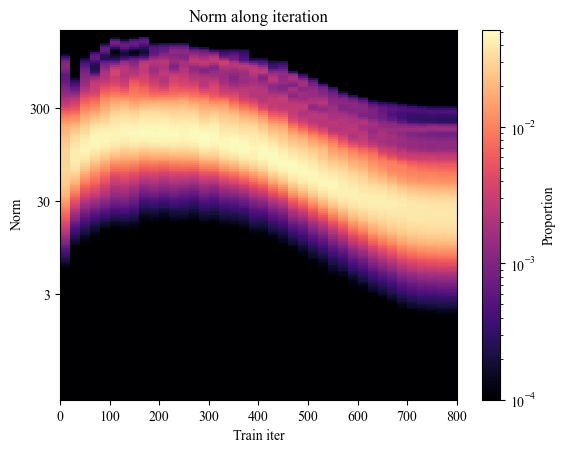




Visualizing spatial_atts


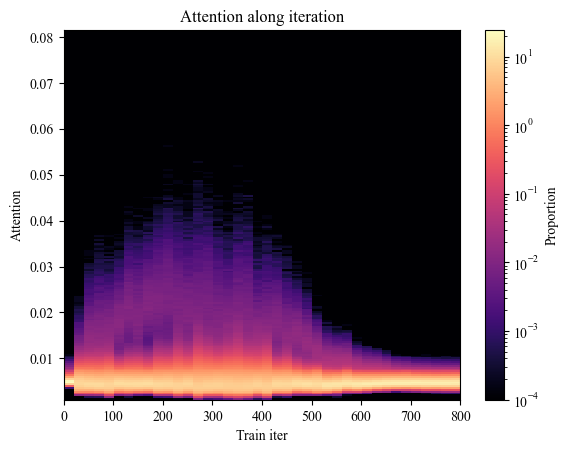

In [ ]:
checkpoints = [f"checkpoint{a}.pth" for a in range(19, 800, 20)]

print(checkpoints)

visualize_along_iterations(checkpoints=checkpoints,
                           data_loader=data_loader,
                           registers=False,
                           layers_to_visualize=[11],
                           maps_to_visualize=["spatial_embs", "spatial_atts"],
                           layers_total=12,
                           n_batches=32,
                           model_batch_size=10,
                           max_iter=800,
                           min_density=1e-4,
)

<ipython-input-14-875f458ee796>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODELS_PATH[path] + "/" + checkpoint_name,





Visualizing spatial_embs


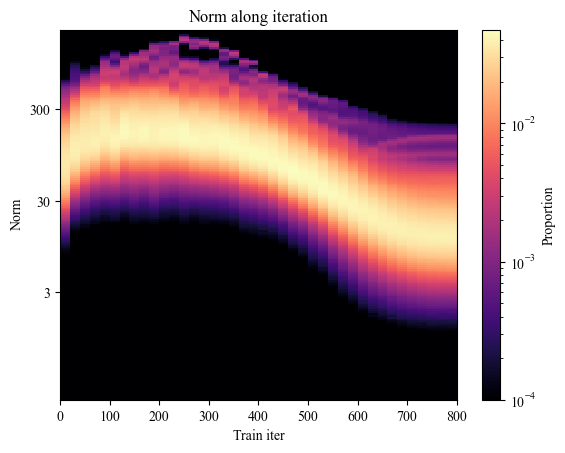




Visualizing spatial_atts


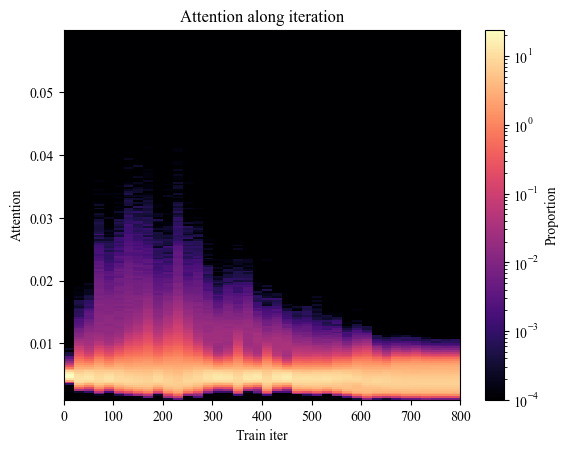

In [ ]:
visualize_along_iterations(checkpoints=checkpoints,
                           data_loader=data_loader,
                           registers=True,
                           layers_to_visualize=[11],
                           maps_to_visualize=["spatial_embs","spatial_atts"],
                           layers_total=12,
                           n_batches=32,
                           model_batch_size=10,
                           max_iter=800,
                           min_density=1e-4,
)

<br><br>

---

<br><br>

# Experiment: Global information in low and high norm tokens

To evaluate how much global information is held in each individual token, predict the global class from individual tokens.

Like in Vision tranformers Need Registers, we use Logistic Regressors as a simple classification method.
To ensure that the training data is evenly weighted, the method choose one high norm token (l2 norm > 150) and one normal one (< 150) per sample image.
Optionally, prefix tokens can be added into the comparison

In [22]:
# @title evaluate class by patch

def _get_token_subset(model,
                     data_loader,
                     layer_to_evaluate: int,
                     n_batches: int,
                     layers_total: int,
                     select_by: str = "norm", # norm or attention
                     prefix: str = "CLS", # none, CLS or all
                     threshold: float | str = "auto",
                     debug=False,
                     ):

  x = defaultdict(list)
  y = []
  norm_means = []

  for i, (input_tensor, labels) in tqdm(enumerate(data_loader), total=n_batches):
    if i == n_batches:
      break

    input_tensor = input_tensor.to(device)
    intermediates = get_all_intermediates(model, input_tensor, layers_total, )  # Extract embeddings

    token_embeddings = intermediates["spatial_embs"][layer_to_evaluate]
    # token_embeddings shape is [batch, height, width, embedding_dim]

    # flatten height and width into single axis
    token_embeddings = token_embeddings.reshape(token_embeddings.shape[0], -1, token_embeddings.shape[-1])
    token_norms = np.linalg.norm(token_embeddings, axis=-1)  # [batch, num_tokens]
    print(token_norms.shape) if debug and i == 0 else None

    if select_by == "attention":
      token_attention = intermediates["spatial_atts"][layer_to_evaluate]  # [batch, num_heads, num_tokens, num_tokens]
      token_attention = token_attention.mean(axis=(1,2))
      print(token_attention.shape) if debug and i == 0 else None
      token_norms = token_attention

    if prefix != "none":
      prefix_token_embeddings = intermediates["prefix_embs"][layer_to_evaluate]
      print(prefix_token_embeddings.shape) if debug and i == 0 else None

    for img_idx in range(token_embeddings.shape[0]):  # Iterate over the batch
      norms = token_norms[img_idx]
      tokens = token_embeddings[img_idx]

      # divide high norm and low norm
      norm_means.append(np.quantile(norms, 0.98))
      threshold_ = norm_means[-1] if threshold == "auto" else threshold
      high_norm_indices = np.where(norms > threshold_)[0]
      low_norm_indices = np.where(norms < threshold_)[0]

      # skip image if no outliers are present
      if len(high_norm_indices) == 0 or len(low_norm_indices) == 0:
        continue

      # Select one random token from each category for training data
      high_norm_idx = high_norm_indices[np.random.randint(0, len(high_norm_indices), (1,))].item()
      high_norm_token = tokens[high_norm_idx]
      x["high"].append(high_norm_token)

      low_norm_idx = low_norm_indices[np.random.randint(0, len(low_norm_indices), (1,))].item()
      low_norm_token = tokens[low_norm_idx]
      x["low"].append(low_norm_token)

      # add CLS to training data
      if prefix != "none":
        x["CLS"].append(prefix_token_embeddings[img_idx, 0])
        if prefix == "all":
          for prefix_idx in range(1, prefix_token_embeddings.shape[1]):
            x[f"REG{prefix_idx-1}"].append(prefix_token_embeddings[img_idx, prefix_idx])

      y.append(labels[img_idx])

    del input_tensor, intermediates
    torch.cuda.empty_cache()

  y = np.array(y)
  return x, y, norm_means



def evaluate_class_by_patch(
    model,
    data_loader,
    layer_to_evaluate: int = 11,
    layers_total: int = 12,
    threshold: float | str = "auto",
    normalize_tokens: bool = True,
    prefix: str = "CLS",  # none, CLS or all
    common_lr: bool = False,
    train_batches: int | bool = 8,
    resample_test: bool = False,
    test_batches: int | bool = 8,
    debug=False,
    **kwargs,
  ):
    """
    Evaluate class prediction accuracy by patch embeddings from a ViT using Logistic Regression.

    Args:
        model: The Vision Transformer (ViT) model.
        data_loader: DataLoader containing the input dataset.
      layer_to_evaluate: The attention block layer from which to select
        token embeddings.
      layers_total: Total number of layers in the model.
      threshold: decides whether a patch is high or low norm,
        auto uses batch statistics to select 98th percentile
      normalize_tokens: if True use StandardScaler to scale features
      prefix: determines what prefix tokens to evaluate, valid choices are
        "none", "CLS" or "all"
      common_lr: if True, trains all token conditions on the same regressor
      train_batches: number of batches to train on
      resample_test: if True, samples new tokens for evaluation, otherwise use
        training tokens
      test_batchs: number of batches to evaluate on, only relevant when resample_test is True
      debug: if True, print debug information

    Returns:
        None (displays a table and scatterplot of accuracy vs token norm).
    """

    x_train = defaultdict(list)
    scaler = dict()
    y_train = []
    norm_means = []

    model.to(device)

    print(f"Collecting random training samples")

    # Training Phase
    x_train, y_train, norm_means = _get_token_subset(
        model=model,
        data_loader=data_loader,
        layer_to_evaluate=layer_to_evaluate,
        n_batches=train_batches,
        layers_total=layers_total,
        prefix=prefix,
        threshold=threshold,
        debug=debug,
    )

    print(f"Training on {len(y_train)} samples...")
    norm_means = np.array(norm_means)
    threshold_ = norm_means.mean() if threshold == "auto" else threshold
    y_train = np.array(y_train)

    if common_lr:
        lr = LogisticRegression(max_iter=kwargs.get("max_iter", 10000))
        X_train = list()
        for k in x_train.keys():
            # Scale each category by themselves
            if normalize_tokens:
                scaler[k] = StandardScaler().fit(x_train[k])
                x_train[k] = scaler[k].transform(x_train[k])
            X_train.extend(x_train[k])
        X_train = np.array(X_train)
        y_train_repeated = np.repeat(y_train, len(x_train.keys()))
        lr.fit(X_train, y_train_repeated)
    else:
        lrs = {
            k: LogisticRegression(max_iter=kwargs.get("max_iter", 10000))
            for k in x_train.keys()
        }

        for k in lrs.keys():
            X_train = np.array(x_train[k])

            if normalize_tokens:
                scaler[k] = StandardScaler().fit(X_train)
                X_scaled = scaler[k].transform(X_train)
            else:
                X_scaled = X_train

            lrs[k].fit(X_scaled, y_train)

    if resample_test:
        del x_train, y_train
        print(f"Collecting evaluation samples")
        # Evaluation Phase

        eval_tokens, true_labels, _ = _get_token_subset(
            model=model,
            data_loader=data_loader,
            layer_to_evaluate=layer_to_evaluate,
            n_batches=test_batches,
            layers_total=layers_total,
            prefix=prefix,
            threshold=threshold_,
            debug=debug,
        )
    else:
        eval_tokens = x_train
        true_labels = y_train

    model.to("cpu")
    print(f"Evaluating on {len(true_labels)} samples...")
    eval_preds = defaultdict(list)
    eval_acc = dict()

    # Predict for each category
    for k in eval_tokens.keys():
        x = np.array(eval_tokens[k])

        if normalize_tokens:
            x = scaler[k].transform(x)

        prediction = lr.predict(x) if common_lr else lrs[k].predict(x)
        eval_preds[k].extend(prediction)
        eval_acc[k] = accuracy_score(true_labels, prediction)
    print("Finished\n\n")

    # Generate a Table
    table_data = [
        ["Token Norm Range", "Accuracy"],
        [f"High Norm Tokens (>{threshold_:.2f})", f"{eval_acc['high']:.4f}"],
        [f"Low Norm Tokens (<{threshold_:.2f})", f"{eval_acc['low']:.4f}"],
    ]
    if prefix != "none":
        table_data.append([f"CLS Tokens", f"{eval_acc['CLS']:.4f}"])
    if prefix == "all":
        table_data.extend(
            [[reg, f"{eval_acc[reg]:.4f}"] for reg in eval_acc.keys() if reg.startswith("REG")]
        )

    for row in table_data:
        print("{:<30} {:<10}".format(*row))

    if debug:
        # Print class distribution
        print("\n")
        for y in set(true_labels.tolist()):
            print(f"{y}: {np.mean(true_labels == y)}")


In [23]:
model_no_reg = load_models_from_drive("checkpoint799.pth", registers=False)
model_reg = load_models_from_drive("checkpoint799.pth", registers=True)

<ipython-input-13-875f458ee796>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODELS_PATH[path] + "/" + checkpoint_name,


In [24]:
evaluate_class_by_patch(model=model_no_reg,
                        data_loader=data_loader,
                        threshold="auto",
                        train_batches=80,
                        prefix = "CLS",
                        )

  0%|          | 0/80 [00:00<?, ?it/s]

Training on 2560 samples...
Evaluating on 2560 samples...
Finished


Token Norm Range               Accuracy  
High Norm Tokens (>260.16)     0.7098    
Low Norm Tokens (<260.16)      0.7434    
CLS Tokens                     0.8254    


In [ ]:
evaluate_class_by_patch(model=model_reg,
                        data_loader=data_loader,
                        threshold=180,
                        prefix="all",
                        train_batches=len(data_loader),
                        normalize_tokens=True
                        )

  0%|          | 0/296 [00:00<?, ?it/s]

Training on 8948 samples...
Evaluating on 8948 samples...
Finished


Token Norm Range               Accuracy  
High Norm Tokens (>180.00)     0.7142    
Low Norm Tokens (<180.00)      0.6579    
CLS Tokens                     0.7167    
REG0                           0.6902    
REG1                           0.7273    
REG2                           0.7395    
REG3                           0.7359    


In [ ]:
for dl in [data_loader_Caltech101, data_loader_Flowers102, data_loader_CIFAR10]:
  evaluate_class_by_patch(model=model_no_reg,
                          data_loader=dl,
                          threshold=180,
                          train_batches=min(len(dl), 512)
                          )
  evaluate_class_by_patch(model=model_reg,
                          data_loader=dl,
                          threshold=180,
                          prefix="all",
                          train_batches=min(len(dl), 512)
                          )

  Token Norm Range               Accuracy
High Norm Tokens (>180.00)     0.3902
Low Norm Tokens (<180.00)      0.4307
CLS Tokens                     0.5812
REG0                           0.5142
REG1                           0.5967
REG2                           0.5894
REG3                           0.6078

  0%|          | 0/136 [00:00<?, ?it/s]

Training on 8603 samples...
Evaluating on 8603 samples...
Finished


Token Norm Range               Accuracy  
High Norm Tokens (>180.00)     0.3902    
Low Norm Tokens (<180.00)      0.4736    
CLS Tokens                     0.4521    


  0%|          | 0/136 [00:00<?, ?it/s]

Training on 8019 samples...
Evaluating on 8019 samples...
Finished


Token Norm Range               Accuracy  
High Norm Tokens (>180.00)     0.3902    
Low Norm Tokens (<180.00)      0.4307    
CLS Tokens                     0.5812    
REG0                           0.5142    
REG1                           0.5967    
REG2                           0.5894    
REG3                           0.6078    


  0%|          | 0/16 [00:00<?, ?it/s]

Training on 1016 samples...
Evaluating on 1016 samples...
Finished


Token Norm Range               Accuracy  
High Norm Tokens (>180.00)     0.8159    
Low Norm Tokens (<180.00)      0.7697    
CLS Tokens                     0.5443    


  0%|          | 0/16 [00:00<?, ?it/s]

Training on 984 samples...
Evaluating on 984 samples...
Finished


Token Norm Range               Accuracy  
High Norm Tokens (>180.00)     0.8161    
Low Norm Tokens (<180.00)      0.6148    
CLS Tokens                     0.5467    
REG0                           0.5701    
REG1                           0.5874    
REG2                           0.5793    
REG3                           0.5335    


  0%|          | 0/512 [00:00<?, ?it/s]

Training on 7965 samples...
Evaluating on 7965 samples...
Finished


Token Norm Range               Accuracy  
High Norm Tokens (>180.00)     0.5784    
Low Norm Tokens (<180.00)      0.6192    
CLS Tokens                     0.6306    


  0%|          | 0/512 [00:00<?, ?it/s]

Training on 1223 samples...
Evaluating on 1223 samples...
Finished


Token Norm Range               Accuracy  
High Norm Tokens (>180.00)     0.5151    
Low Norm Tokens (<180.00)      0.5487    
CLS Tokens                     0.6304    
REG0                           0.6492    
REG1                           0.6386    
REG2                           0.6468    
REG3                           0.6271    


In [ ]:
for dl in [data_loader, data_loader_Caltech101, data_loader_Flowers102, data_loader_CIFAR10]:
  evaluate_class_by_patch(model=model_no_reg,
                          data_loader=dl,
                          threshold=150,
                          train_batches=len(dl)
                          )
  evaluate_class_by_patch(model=model_reg,
                          data_loader=dl,
                          threshold=150,
                          prefix="all",
                          train_batches=len(dl)
                          )


  0%|          | 0/296 [00:00<?, ?it/s]

Training on 8892 samples...
Evaluating on 8892 samples...
Finished


Token Norm Range               Accuracy  
High Norm Tokens (>150.00)     0.7170    
Low Norm Tokens (<150.00)      0.7417    
CLS Tokens                     0.6736    


  0%|          | 0/296 [00:00<?, ?it/s]

Training on 9343 samples...
Evaluating on 9343 samples...
Finished


Token Norm Range               Accuracy  
High Norm Tokens (>150.00)     0.7107    
Low Norm Tokens (<150.00)      0.6730    
CLS Tokens                     0.7211    
REG0                           0.6927    
REG1                           0.7294    
REG2                           0.7418    
REG3                           0.7384    


  0%|          | 0/136 [00:00<?, ?it/s]

Training on 8287 samples...
Evaluating on 8287 samples...
Finished


Token Norm Range               Accuracy  
High Norm Tokens (>150.00)     0.3810    
Low Norm Tokens (<150.00)      0.5034    
CLS Tokens                     0.4537    


  0%|          | 0/136 [00:00<?, ?it/s]

Training on 8555 samples...
Evaluating on 8555 samples...
Finished


Token Norm Range               Accuracy  
High Norm Tokens (>150.00)     0.3912    
Low Norm Tokens (<150.00)      0.4674    
CLS Tokens                     0.5840    
REG0                           0.5158    
REG1                           0.5992    
REG2                           0.5892    
REG3                           0.6131    


  0%|          | 0/16 [00:00<?, ?it/s]

Training on 929 samples...
Evaluating on 929 samples...
Finished


Token Norm Range               Accuracy  
High Norm Tokens (>150.00)     0.7287    
Low Norm Tokens (<150.00)      0.8644    
CLS Tokens                     0.5145    


  0%|          | 0/16 [00:00<?, ?it/s]

Training on 1015 samples...
Evaluating on 1015 samples...
Finished


Token Norm Range               Accuracy  
High Norm Tokens (>150.00)     0.8236    
Low Norm Tokens (<150.00)      0.6453    
CLS Tokens                     0.5507    
REG0                           0.5655    
REG1                           0.5882    
REG2                           0.5724    
REG3                           0.5389    


  0%|          | 0/782 [00:00<?, ?it/s]

Training on 18564 samples...
Evaluating on 18564 samples...
Finished


Token Norm Range               Accuracy  
High Norm Tokens (>150.00)     0.5818    
Low Norm Tokens (<150.00)      0.6273    
CLS Tokens                     0.6163    


  0%|          | 0/782 [00:00<?, ?it/s]

Training on 7250 samples...
Evaluating on 7250 samples...
Finished


Token Norm Range               Accuracy  
High Norm Tokens (>150.00)     0.5279    
Low Norm Tokens (<150.00)      0.5738    
CLS Tokens                     0.6310    
REG0                           0.6436    
REG1                           0.6563    
REG2                           0.6530    
REG3                           0.6418    
